# Punishment Study 2.1.2 - NLP Analysis

**Goal**: Analyze open-ended punishment justifications to detect the 'prosocial facade'

**Setup**: Runtime > Change runtime type > GPU (T4)

In [35]:
# SECTION 0: INSTALL PACKAGES
!pip install -q transformers sentence-transformers bertopic umap-learn hdbscan
!pip install -q vaderSentiment empath wordcloud nrclex
!pip install -q plotly kaleido tqdm
print('Installation complete!')

Installation complete!


In [36]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from empath import Empath
from nrclex import NRCLex
from wordcloud import WordCloud
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
import umap
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm
from google.colab import files

print('Imports complete!')

Imports complete!


In [37]:
# UPLOAD DATA
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(f'Loaded {len(df)} rows')

Saving punishment_212_cleaned_data.csv to punishment_212_cleaned_data (1).csv
Loaded 496 rows


In [38]:
# SECTION 1: TEXT PREPROCESSING
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''
    text = str(text).lower()
    text = ' '.join(text.split())
    text = re.sub(r'[^a-z0-9\s\.\,\!\?\'\-]', '', text)
    return text.strip()

df['text1_clean'] = df['Sentence_OpenEnd1'].apply(clean_text)
df['text2_clean'] = df['Sentence_OpenEnd2'].apply(clean_text)
df['text_combined'] = df.apply(lambda r: f"{r['text1_clean']} {r['text2_clean']}".strip(), axis=1)

df['text1_wordcount'] = df['text1_clean'].apply(lambda x: len(x.split()) if x else 0)
df['text2_wordcount'] = df['text2_clean'].apply(lambda x: len(x.split()) if x else 0)
df['text_combined_wordcount'] = df['text1_wordcount'] + df['text2_wordcount']

df_valid = df[df['text_combined_wordcount'] >= 3].copy()
print(f'Valid responses: {len(df_valid)} of {len(df)}')
print(f'Mean word count Q1: {df_valid["text1_wordcount"].mean():.1f}')
print(f'Mean word count Q2: {df_valid["text2_wordcount"].mean():.1f}')

Valid responses: 496 of 496
Mean word count Q1: 28.8
Mean word count Q2: 19.5


In [39]:
# Sample responses
print('=== SAMPLE RESPONSES ===')
for i in range(3):
    print(f'\n--- {i+1} ---')
    print(f"Q1: {df_valid['Sentence_OpenEnd1'].iloc[i]}")
    print(f"Q2: {df_valid['Sentence_OpenEnd2'].iloc[i]}")

=== SAMPLE RESPONSES ===

--- 1 ---
Q1: This was a violent robbery that escalated into a fatal attack
Q2: accountability and rehabilitation 

--- 2 ---
Q1: he deserves jailtime
Q2: rehabilitate and remind

--- 3 ---
Q1: Darryl killed a completely innocent woman, and a stranger, for no reason at all, and in my opinion has forfeit any right to freedom or a normal life because of this.
Q2: Removal of a dangerous and deranged person from society where he cannot harm anyone else.


In [40]:
# SECTION 2: VADER SENTIMENT
vader = SentimentIntensityAnalyzer()

def get_vader(text):
    if not text: return {'neg': np.nan, 'neu': np.nan, 'pos': np.nan, 'compound': np.nan}
    return vader.polarity_scores(text)

print('Computing VADER scores...')
vader_1 = df_valid['text1_clean'].apply(get_vader).apply(pd.Series)
vader_1.columns = ['vader1_neg', 'vader1_neu', 'vader1_pos', 'vader1_compound']
vader_2 = df_valid['text2_clean'].apply(get_vader).apply(pd.Series)
vader_2.columns = ['vader2_neg', 'vader2_neu', 'vader2_pos', 'vader2_compound']
vader_c = df_valid['text_combined'].apply(get_vader).apply(pd.Series)
vader_c.columns = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

df_valid = pd.concat([df_valid, vader_1, vader_2, vader_c], axis=1)
print(f'Mean compound sentiment: {df_valid["vader_compound"].mean():.3f}')

Computing VADER scores...
Mean compound sentiment: -0.501


In [41]:
# SECTION 2B: EMPATH CATEGORIES
lexicon = Empath()
empath_cats = ['violence', 'crime', 'death', 'pain', 'suffering', 'negative_emotion', 'positive_emotion',
               'anger', 'fear', 'hate', 'disgust', 'sympathy', 'help', 'government', 'law', 'order', 'power',
               'family', 'children', 'healing', 'prison', 'weapon', 'fight', 'kill', 'trust', 'achievement']

def get_empath(text):
    if not text: return {c: 0 for c in empath_cats}
    scores = lexicon.analyze(text, categories=empath_cats, normalize=True)
    return scores if scores else {c: 0 for c in empath_cats}

print('Computing Empath scores...')
empath_df = df_valid['text_combined'].apply(get_empath).apply(pd.Series)
empath_df.columns = ['empath_' + c for c in empath_df.columns]
df_valid = pd.concat([df_valid, empath_df.fillna(0)], axis=1)
print('Empath complete!')

Computing Empath scores...
Empath complete!


In [42]:
# SECTION 2C: CUSTOM JUSTIFICATION DICTIONARY
punishment_dict = {
    'deterrence': ['deter', 'prevent', 'discourage', 'warning', 'example', 'lesson', 'think twice', 'stop others'],
    'incapacitation': ['protect', 'safety', 'safe', 'remove', 'dangerous', 'threat', 'public', 'keep away', 'off the streets'],
    'rehabilitation': ['rehabilitate', 'reform', 'change', 'learn', 'treatment', 'therapy', 'help', 'improve', 'better person', 'second chance', 'program', 'education'],
    'retribution': ['deserve', 'fair', 'just', 'justice', 'proportional', 'appropriate', 'consequences', 'accountable', 'responsible', 'pay for'],
    'norm_expression': ['wrong', 'unacceptable', 'society', 'values', 'moral', 'message', 'condemn', 'show', 'signal'],
    'revenge': ['revenge', 'vengeance', 'payback', 'get back', 'retaliate', 'eye for', 'taste of'],
    'suffering': ['suffer', 'pain', 'hurt', 'agony', 'torment', 'misery', 'feel what', 'rot'],
    'degradation': ['humiliate', 'shame', 'disgrace', 'worthless', 'scum', 'animal', 'monster'],
    'exclusion': ['remove', 'rid', 'eliminate', 'banish', 'no place', 'throw away', 'lock up forever'],
    'victim_focus': ['victim', 'family', 'closure', 'peace', 'loved ones']
}

def count_dict_words(text, word_dict):
    if not text: return {k: 0 for k in word_dict}
    text_lower = text.lower()
    words = text_lower.split()
    wc = len(words) if words else 1
    scores = {}
    for cat, wordlist in word_dict.items():
        count = sum(1 for w in words if any(w.startswith(term) for term in wordlist if ' ' not in term))
        count += sum(text_lower.count(term) for term in wordlist if ' ' in term)
        scores[cat] = count / wc
    return scores

print('Computing custom dictionary scores...')
just_df = df_valid['text_combined'].apply(lambda x: count_dict_words(x, punishment_dict)).apply(pd.Series)
just_df.columns = ['just_' + c for c in just_df.columns]
df_valid = pd.concat([df_valid, just_df], axis=1)

# Aggregates
prosocial = ['just_deterrence', 'just_incapacitation', 'just_rehabilitation', 'just_retribution', 'just_norm_expression']
dark = ['just_revenge', 'just_suffering', 'just_degradation', 'just_exclusion']
df_valid['just_prosocial'] = df_valid[prosocial].sum(axis=1)
df_valid['just_dark'] = df_valid[dark].sum(axis=1)
df_valid['just_prosocial_minus_dark'] = df_valid['just_prosocial'] - df_valid['just_dark']
print('Dictionary analysis complete!')

Computing custom dictionary scores...
Dictionary analysis complete!


In [43]:
# SECTION 3: ZERO-SHOT CLASSIFICATION
print('Loading zero-shot model...')
classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device=0)

labels = [
    'deterrence and prevention', 'public safety and protection', 'rehabilitation and reform',
    'proportional justice', 'revenge and payback', 'punishment and suffering',
    'victim closure', 'societal condemnation'
]

def classify_text(text):
    if not text or len(text.split()) < 3:
        return {l: np.nan for l in labels}
    try:
        result = classifier(text[:512], labels, multi_label=True)
        return dict(zip(result['labels'], result['scores']))
    except:
        return {l: np.nan for l in labels}

print('Running zero-shot classification')
zs_results = []
for text in tqdm(df_valid['text_combined'].tolist()):
    zs_results.append(classify_text(text))

zs_df = pd.DataFrame(zs_results)
zs_df.columns = ['zs_' + c.replace(' ', '_') for c in zs_df.columns]
zs_df.index = df_valid.index
df_valid = pd.concat([df_valid, zs_df], axis=1)

# Aggregates
zs_prosocial = [c for c in zs_df.columns if any(x in c for x in ['deterrence', 'safety', 'rehabilitation', 'justice'])]
zs_dark = [c for c in zs_df.columns if any(x in c for x in ['revenge', 'suffering'])]
if zs_prosocial: df_valid['zs_prosocial_mean'] = df_valid[zs_prosocial].mean(axis=1)
if zs_dark: df_valid['zs_dark_mean'] = df_valid[zs_dark].mean(axis=1)
if zs_prosocial and zs_dark: df_valid['zs_prosocial_minus_dark'] = df_valid['zs_prosocial_mean'] - df_valid['zs_dark_mean']
print('Zero-shot complete!')

Loading zero-shot model...


Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

Running zero-shot classification


100%|██████████| 496/496 [02:25<00:00,  3.40it/s]

Zero-shot complete!


# SECTION 3A: FORCED-CHOICE ZERO-SHOT CLASSIFICATION

The multi-label classification (`multi_label=True`) assigns high probabilities to multiple categories simultaneously.  
As the calibration analysis shows, the mean deterrence score is ~0.85 but punishment/suffering is ~0.72 —
BART says "both" for most responses. This inflates the apparent dominance of any single category.

**Forced-choice** (`multi_label=False`) forces BART to distribute probability across categories as a
proper probability distribution (sums to 1.0), giving a cleaner picture of what BART considers the
*primary* justification for each response.


In [44]:
# SECTION 3A: FORCED-CHOICE ZERO-SHOT CLASSIFICATION
print('=' * 70)
print('FORCED-CHOICE ZERO-SHOT CLASSIFICATION (multi_label=False)')
print('=' * 70)

def classify_text_forced(text):
    if not text or len(text.split()) < 3:
        return {l: np.nan for l in labels}
    try:
        result = classifier(text[:512], labels, multi_label=False)
        return dict(zip(result['labels'], result['scores']))
    except:
        return {l: np.nan for l in labels}

print('Running forced-choice classification (this may take a few minutes)...')
fc_results = []
for text in tqdm(df_valid['text_combined'].tolist()):
    fc_results.append(classify_text_forced(text))

fc_df = pd.DataFrame(fc_results)
fc_df.columns = ['fc_' + c.replace(' ', '_') for c in fc_df.columns]
fc_df.index = df_valid.index
df_valid = pd.concat([df_valid, fc_df], axis=1)

# Aggregates
fc_prosocial = [c for c in fc_df.columns if any(x in c for x in ['deterrence', 'safety', 'rehabilitation', 'justice'])]
fc_dark = [c for c in fc_df.columns if any(x in c for x in ['revenge', 'suffering'])]
if fc_prosocial: df_valid['fc_prosocial_mean'] = df_valid[fc_prosocial].mean(axis=1)
if fc_dark: df_valid['fc_dark_mean'] = df_valid[fc_dark].mean(axis=1)
if fc_prosocial and fc_dark: df_valid['fc_prosocial_minus_dark'] = df_valid['fc_prosocial_mean'] - df_valid['fc_dark_mean']

print('\nForced-choice classification complete!')

# ---- COMPARISON: multi-label vs forced-choice ----
print('\n' + '=' * 70)
print('COMPARISON: MULTI-LABEL vs FORCED-CHOICE')
print('=' * 70)

# Top classification under each method
fc_top_cols = [c for c in fc_df.columns]
zs_top_cols = [c for c in df_valid.columns if c.startswith('zs_') and c not in
               ['zs_prosocial_mean', 'zs_dark_mean', 'zs_prosocial_minus_dark']]

def get_top_label(row, cols, prefix):
    vals = pd.to_numeric(row[cols], errors='coerce').dropna()
    if len(vals) == 0:
        return np.nan
    return vals.idxmax().replace(prefix, '')

df_valid['ml_top'] = df_valid.apply(lambda r: get_top_label(r, zs_top_cols, 'zs_'), axis=1)
df_valid['fc_top'] = df_valid.apply(lambda r: get_top_label(r, fc_top_cols, 'fc_'), axis=1)

print('\nMULTI-LABEL top classification distribution:')
ml_dist = df_valid['ml_top'].value_counts()
for label, count in ml_dist.items():
    print(f'  {label:40}: {count:4d} ({count/len(df_valid)*100:.1f}%)')

print('\nFORCED-CHOICE top classification distribution:')
fc_dist = df_valid['fc_top'].value_counts()
for label, count in fc_dist.items():
    print(f'  {label:40}: {count:4d} ({count/len(df_valid)*100:.1f}%)')

# Mean probability per category
print('\nMean probability per category:')
print(f'{" ":40} {"Multi-Label":>12} {"Forced-Choice":>14}')
print('-' * 70)
for label in labels:
    ml_col = 'zs_' + label.replace(' ', '_')
    fc_col = 'fc_' + label.replace(' ', '_')
    ml_mean = pd.to_numeric(df_valid[ml_col], errors='coerce').mean() if ml_col in df_valid.columns else np.nan
    fc_mean = pd.to_numeric(df_valid[fc_col], errors='coerce').mean() if fc_col in df_valid.columns else np.nan
    print(f'  {label:38}: {ml_mean:12.3f} {fc_mean:14.3f}')

# Agreement between methods
agree = (df_valid['ml_top'] == df_valid['fc_top']).mean()
print(f'\nAgreement on top category: {agree:.1%}')

# Crosstab
print('\nCrosstab (Multi-Label rows × Forced-Choice columns):')
ct = pd.crosstab(df_valid['ml_top'], df_valid['fc_top'], margins=True)
print(ct.to_string())

# KEY: prosocial percentage under each method
ml_prosocial_cats = {'deterrence_and_prevention', 'public_safety_and_protection',
                     'rehabilitation_and_reform', 'proportional_justice',
                     'victim_closure', 'societal_condemnation'}
ml_pct_prosocial = df_valid['ml_top'].apply(lambda x: x in ml_prosocial_cats if pd.notna(x) else False).mean() * 100
fc_pct_prosocial = df_valid['fc_top'].apply(lambda x: x in ml_prosocial_cats if pd.notna(x) else False).mean() * 100

print(f'\n{"="*70}')
print(f'KEY COMPARISON:')
print(f'  % classified as prosocial (multi-label):   {ml_pct_prosocial:.1f}%')
print(f'  % classified as prosocial (forced-choice): {fc_pct_prosocial:.1f}%')
print(f'  Difference: {ml_pct_prosocial - fc_pct_prosocial:+.1f} percentage points')
print(f'{"="*70}')

if fc_pct_prosocial < ml_pct_prosocial - 5:
    print('NOTE: Forced-choice substantially REDUCES the prosocial percentage.')
    print('The multi-label 85% figure was inflated by BART assigning high scores to many categories.')
elif fc_pct_prosocial > ml_pct_prosocial + 5:
    print('NOTE: Forced-choice substantially INCREASES the prosocial percentage.')
else:
    print('NOTE: Both methods give similar prosocial percentages.')


FORCED-CHOICE ZERO-SHOT CLASSIFICATION (multi_label=False)
Running forced-choice classification (this may take a few minutes)...


100%|██████████| 496/496 [02:03<00:00,  4.02it/s]



Forced-choice classification complete!

COMPARISON: MULTI-LABEL vs FORCED-CHOICE

MULTI-LABEL top classification distribution:
  deterrence_and_prevention               :  251 (50.6%)
  proportional_justice                    :   59 (11.9%)
  public_safety_and_protection            :   45 (9.1%)
  punishment_and_suffering                :   39 (7.9%)
  societal_condemnation                   :   37 (7.5%)
  rehabilitation_and_reform               :   28 (5.6%)
  revenge_and_payback                     :   23 (4.6%)
  victim_closure                          :   14 (2.8%)

FORCED-CHOICE top classification distribution:
  deterrence_and_prevention               :  198 (39.9%)
  punishment_and_suffering                :   81 (16.3%)
  proportional_justice                    :   59 (11.9%)
  rehabilitation_and_reform               :   42 (8.5%)
  public_safety_and_protection            :   40 (8.1%)
  societal_condemnation                   :   37 (7.5%)
  victim_closure                   

# SECTION 3B: ZERO-SHOT CLASSIFIER VALIDATION

**Note**: Validation A2 (Cross-Method Convergence) is placed after the Prototype Sentences
section because it requires outputs from all four classification methods (BART multi-label,
BART forced-choice, dictionary, and BERT similarity). See cell below Section 4B.

**Motivation**: The zero-shot classifier (BART) has not been validated on punishment justification text.
We cannot simply trust that it classifies appropriately (feedback from lab meeting).
Three validation strategies are implemented below — none require hand-coding.

**Strategy A1**: Synthetic benchmark with unambiguous sentences  
**Strategy A2**: Cross-method convergent validity (BART vs dictionary vs BERT similarity)  
**Strategy A3**: Calibration analysis (do BART confidence scores correlate with expected features?)


In [45]:
# SECTION 3B-A1: SYNTHETIC BENCHMARK VALIDATION
# Create unambiguous test sentences with known ground truth
print('=' * 70)
print('VALIDATION A1: SYNTHETIC BENCHMARK')
print('=' * 70)

benchmark_sentences = {
    'deterrence and prevention': [
        'This sentence will make others think twice before committing crimes.',
        'The punishment should send a clear warning to would-be offenders.',
        'By punishing this crime severely, we prevent future crimes from happening.',
        'Others who might consider committing a crime will be scared straight.',
        'A strong punishment deters criminal behavior in the community.',
    ],
    'public safety and protection': [
        'We need to keep this dangerous person away from the public.',
        'Society is safer when violent offenders are behind bars.',
        'This sentence protects innocent people from a threat.',
        'The community needs to be shielded from criminals like this.',
        'Keeping offenders locked up prevents them from hurting anyone else.',
    ],
    'rehabilitation and reform': [
        'Prison should give this person a chance to turn their life around.',
        'With proper therapy and education, this offender can become a better person.',
        'Everyone deserves a second chance to reform and reenter society.',
        'The goal of prison should be helping offenders become productive citizens.',
        'I hope this person receives treatment and learns from their mistakes.',
    ],
    'proportional justice': [
        'The punishment should fit the severity of the crime committed.',
        'This is a fair and proportionate sentence for what was done.',
        'Justice demands that the consequence match the offense.',
        'This sentence appropriately reflects how serious the crime was.',
        'The offender deserves a punishment that is neither too harsh nor too lenient.',
    ],
    'revenge and payback': [
        'He should get a taste of his own medicine.',
        'An eye for an eye. He needs to pay for what he did.',
        'This is payback for the suffering he caused.',
        'I want him to feel the same pain he inflicted on others.',
        'He deserves vengeance for the harm he brought upon his victim.',
    ],
    'punishment and suffering': [
        'I want him to suffer every day in prison.',
        'Prison should be as painful and miserable as possible for him.',
        'Let him rot and experience agony behind bars.',
        'He deserves to feel torment for the rest of his life.',
        'Prison should be a living hell for someone who did this.',
    ],
    'victim closure': [
        'The victim\'s family deserves to see justice served.',
        'This sentence provides some peace to the loved ones affected.',
        'The family needs closure after what happened to them.',
        'Seeing the offender punished can help the victims begin to heal.',
        'This is for the family who lost someone they loved.',
    ],
    'societal condemnation': [
        'Society needs to show that this behavior is completely unacceptable.',
        'This sentence sends a moral message about our values.',
        'We as a society condemn this kind of violence.',
        'The punishment expresses our collective disapproval of murder.',
        'This conviction upholds the moral standards of our community.',
    ],
}

# Run benchmark through classifier
print('Running benchmark sentences through BART...')
benchmark_results = []
for true_label, sentences in benchmark_sentences.items():
    for sent in sentences:
        result = classifier(sent, labels, multi_label=True)
        pred_label = result['labels'][0]  # top prediction
        pred_score = result['scores'][0]
        # Also get the score for the true label
        label_idx = result['labels'].index(true_label)
        true_score = result['scores'][label_idx]
        true_rank = label_idx + 1
        benchmark_results.append({
            'true_label': true_label,
            'predicted_label': pred_label,
            'correct_top1': pred_label == true_label,
            'true_label_score': true_score,
            'true_label_rank': true_rank,
            'pred_confidence': pred_score,
            'sentence': sent[:80]
        })

bench_df = pd.DataFrame(benchmark_results)

# Overall accuracy
top1_acc = bench_df['correct_top1'].mean()
top2_acc = (bench_df['true_label_rank'] <= 2).mean()
top3_acc = (bench_df['true_label_rank'] <= 3).mean()
print(f'\nOVERALL BENCHMARK ACCURACY:')
print(f'  Top-1 accuracy: {top1_acc:.1%} ({bench_df["correct_top1"].sum()}/{len(bench_df)})')
print(f'  Top-2 accuracy: {top2_acc:.1%}')
print(f'  Top-3 accuracy: {top3_acc:.1%}')
print(f'  Mean true-label score: {bench_df["true_label_score"].mean():.3f}')
print(f'  Mean true-label rank: {bench_df["true_label_rank"].mean():.2f}')

# Per-category accuracy
print(f'\nPER-CATEGORY TOP-1 ACCURACY:')
print('-' * 50)
for label in labels:
    cat_df = bench_df[bench_df['true_label'] == label]
    acc = cat_df['correct_top1'].mean()
    mean_score = cat_df['true_label_score'].mean()
    print(f'  {label:35}: {acc:.0%} (mean score: {mean_score:.3f})')

# Confusion: what does BART confuse?
print(f'\nCONFUSION PATTERNS (misclassified sentences):')
misclass = bench_df[~bench_df['correct_top1']]
if len(misclass) > 0:
    for _, row in misclass.iterrows():
        print(f'  TRUE: {row["true_label"][:25]:25} -> PRED: {row["predicted_label"][:25]:25} | "{row["sentence"]}"')
else:
    print('  No misclassifications!')

bench_df.to_csv('zs_benchmark_validation.csv', index=False)
print('\nSaved: zs_benchmark_validation.csv')


VALIDATION A1: SYNTHETIC BENCHMARK
Running benchmark sentences through BART...

OVERALL BENCHMARK ACCURACY:
  Top-1 accuracy: 77.5% (31/40)
  Top-2 accuracy: 92.5%
  Top-3 accuracy: 95.0%
  Mean true-label score: 0.932
  Mean true-label rank: 1.40

PER-CATEGORY TOP-1 ACCURACY:
--------------------------------------------------
  deterrence and prevention          : 100% (mean score: 0.998)
  public safety and protection       : 40% (mean score: 0.996)
  rehabilitation and reform          : 100% (mean score: 0.971)
  proportional justice               : 100% (mean score: 0.980)
  revenge and payback                : 40% (mean score: 0.995)
  punishment and suffering           : 100% (mean score: 0.997)
  victim closure                     : 100% (mean score: 0.921)
  societal condemnation              : 40% (mean score: 0.600)

CONFUSION PATTERNS (misclassified sentences):
  TRUE: public safety and protect -> PRED: deterrence and prevention | "We need to keep this dangerous person away 

In [46]:
# SECTION 3B-A3: CALIBRATION ANALYSIS
# Does BART confidence correlate with expected external features?
print('=' * 70)
print('VALIDATION A3: CALIBRATION ANALYSIS')
print('=' * 70)

# Q1: Do high-confidence deterrence classifications contain more deterrence dictionary words?
print('\n--- Q1: BART deterrence confidence vs dictionary deterrence words ---')
mask = df_valid[['zs_deterrence_and_prevention', 'just_deterrence']].notna().all(axis=1)
if mask.sum() > 30:
    r, p = pearsonr(df_valid.loc[mask, 'zs_deterrence_and_prevention'].values.astype(float), df_valid.loc[mask, 'just_deterrence'].values.astype(float))
    print(f'  r = {r:.3f}, p = {p:.4f}')
    print(f'  Interpretation: {"GOOD" if r > 0.1 else "WEAK"} - BART deterrence score {"does" if r > 0.1 else "does NOT"} correlate with deterrence vocabulary')

# Q2: Do high-confidence revenge classifications come from more hostile participants?
print('\n--- Q2: BART revenge confidence vs hostile aggression score ---')
mask = df_valid[['zs_revenge_and_payback', 'hostile_agg']].notna().all(axis=1)
if mask.sum() > 30:
    r, p = pearsonr(df_valid.loc[mask, 'zs_revenge_and_payback'].values.astype(float), df_valid.loc[mask, 'hostile_agg'].values.astype(float))
    print(f'  r = {r:.3f}, p = {p:.4f}')
    print(f'  Interpretation: {"GOOD" if r > 0.05 else "WEAK"} - BART revenge score {"does" if r > 0.05 else "does NOT"} correlate with hostile aggression')

# Q3: Do high-confidence rehabilitation classifications contain rehabilitation dictionary words?
print('\n--- Q3: BART rehabilitation confidence vs dictionary rehabilitation words ---')
mask = df_valid[['zs_rehabilitation_and_reform', 'just_rehabilitation']].notna().all(axis=1)
if mask.sum() > 30:
    r, p = pearsonr(df_valid.loc[mask, 'zs_rehabilitation_and_reform'].values.astype(float), df_valid.loc[mask, 'just_rehabilitation'].values.astype(float))
    print(f'  r = {r:.3f}, p = {p:.4f}')

# Q4: Does BART suffering classification correlate with VADER negative sentiment?
print('\n--- Q4: BART suffering confidence vs VADER negative sentiment ---')
mask = df_valid[['zs_punishment_and_suffering', 'vader_neg']].notna().all(axis=1)
if mask.sum() > 30:
    r, p = pearsonr(df_valid.loc[mask, 'zs_punishment_and_suffering'].values.astype(float), df_valid.loc[mask, 'vader_neg'].values.astype(float))
    print(f'  r = {r:.3f}, p = {p:.4f}')

# Q5: Base rate analysis - does BART assign uniformly high deterrence scores?
print('\n--- Q5: BART base rate analysis (is deterrence always high?) ---')
zs_means = {}
for label in labels:
    col = 'zs_' + label.replace(' ', '_')
    if col in df_valid.columns:
        zs_means[label] = df_valid[col].mean()
print('Mean BART probability per category:')
for label, mean_prob in sorted(zs_means.items(), key=lambda x: -x[1]):
    print(f'  {label:35}: {mean_prob:.3f}')

# Q6: Full calibration matrix - all BART categories vs all dictionary categories
print('\n--- Q6: Full BART x Dictionary correlation matrix ---')
zs_cols_cal = [c for c in df_valid.columns if c.startswith('zs_') and
               c not in ['zs_prosocial_mean', 'zs_dark_mean', 'zs_prosocial_minus_dark']]
dict_cols_cal = [c for c in df_valid.columns if c.startswith('just_') and
                 c not in ['just_prosocial', 'just_dark', 'just_prosocial_minus_dark']]

cal_results = []
for zc in zs_cols_cal:
    for dc in dict_cols_cal:
        try:
            x = pd.to_numeric(df_valid[zc], errors='coerce')
            y = pd.to_numeric(df_valid[dc], errors='coerce')
            mask = x.notna() & y.notna()
            if mask.sum() > 30:
                r, p = pearsonr(x[mask].values.astype(float), y[mask].values.astype(float))
                cal_results.append({'BART': zc.replace('zs_',''), 'Dict': dc.replace('just_',''), 'r': r, 'p': p})
        except Exception as e:
            print(f'  Skipping {zc} x {dc}: {e}')

cal_df = pd.DataFrame(cal_results)
# Show only "on-diagonal" matches (same concept across methods)
concept_map = {
    'deterrence_and_prevention': 'deterrence',
    'rehabilitation_and_reform': 'rehabilitation',
    'revenge_and_payback': 'revenge',
    'punishment_and_suffering': 'suffering',
    'proportional_justice': 'retribution',
    'societal_condemnation': 'norm_expression',
    'public_safety_and_protection': 'incapacitation',
    'victim_closure': 'victim_focus'
}
print('\nON-DIAGONAL (same concept) correlations:')
for bart_cat, dict_cat in concept_map.items():
    match = cal_df[(cal_df['BART'] == bart_cat) & (cal_df['Dict'] == dict_cat)]
    if len(match) > 0:
        row = match.iloc[0]
        sig = '***' if row['p'] < .001 else '**' if row['p'] < .01 else '*' if row['p'] < .05 else 'ns'
        print(f'  BART:{bart_cat:35} x Dict:{dict_cat:15} r={row["r"]:.3f} {sig}')

cal_df.to_csv('zs_calibration_matrix.csv', index=False)
print('\nSaved: zs_calibration_matrix.csv')


VALIDATION A3: CALIBRATION ANALYSIS

--- Q1: BART deterrence confidence vs dictionary deterrence words ---
  r = 0.190, p = 0.0000
  Interpretation: GOOD - BART deterrence score does correlate with deterrence vocabulary

--- Q2: BART revenge confidence vs hostile aggression score ---
  r = 0.124, p = 0.0055
  Interpretation: GOOD - BART revenge score does correlate with hostile aggression

--- Q3: BART rehabilitation confidence vs dictionary rehabilitation words ---
  r = 0.437, p = 0.0000

--- Q4: BART suffering confidence vs VADER negative sentiment ---
  r = 0.253, p = 0.0000

--- Q5: BART base rate analysis (is deterrence always high?) ---
Mean BART probability per category:
  deterrence and prevention          : 0.853
  proportional justice               : 0.796
  societal condemnation              : 0.732
  punishment and suffering           : 0.721
  public safety and protection       : 0.652
  victim closure                     : 0.593
  revenge and payback                : 0.3

In [47]:
# SECTION 4: EMBEDDINGS
print('Loading embedding model (all-mpnet-base-v2)...')
embedding_model = SentenceTransformer('all-mpnet-base-v2')

print('Generating embeddings...')
texts = [t if t else 'no response' for t in df_valid['text_combined'].tolist()]
embeddings = embedding_model.encode(texts, show_progress_bar=True, batch_size=32)
print(f'Embeddings shape: {embeddings.shape}')

Loading embedding model (all-mpnet-base-v2)...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating embeddings...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Embeddings shape: (496, 768)


In [48]:
# SECTION 4B: PROTOTYPE SENTENCES
prototypes = {
    'proto_deterrence': [
        'This sentence will deter others from committing similar crimes.',
        'Punishment sends a message that crime does not pay.',
        'This will make others think twice before breaking the law.'
    ],
    'proto_incapacitation': [
        'This keeps dangerous criminals away from society.',
        'The public needs to be protected from this offender.',
        'Society is safer with this person behind bars.'
    ],
    'proto_rehabilitation': [
        'Time in prison gives the offender a chance to reform.',
        'With proper programs, this person can become a productive member of society.',
        'Everyone deserves a second chance to become a better person.'
    ],
    'proto_retribution': [
        'This sentence is proportional to the severity of the crime.',
        'Justice requires that wrongdoers face appropriate consequences.',
        'The offender deserves this punishment for their actions.'
    ],
    'proto_revenge': [
        'He deserves to suffer for what he did.',
        'This is payback for the harm he caused.',
        'An eye for an eye - he should feel the same pain.'
    ],
    'proto_suffering': [
        'I want him to suffer in prison.',
        'Prison should be painful and miserable.',
        'Let him rot and suffer behind bars.'
    ],
    'proto_exclusion': [
        'He has no place in our society.',
        'Lock him up and throw away the key.',
        'He forfeited his right to be part of society.'
    ]
}

print('Computing prototype embeddings...')
proto_embeddings = {}
for cat, sents in prototypes.items():
    emb = embedding_model.encode(sents)
    proto_embeddings[cat] = np.mean(emb, axis=0)

print('Computing similarity to prototypes...')
for cat, proto_emb in proto_embeddings.items():
    sims = cosine_similarity(embeddings, proto_emb.reshape(1, -1)).flatten()
    df_valid[f'sim_{cat}'] = sims

# Aggregates
prosocial_sim = ['sim_proto_deterrence', 'sim_proto_incapacitation', 'sim_proto_rehabilitation', 'sim_proto_retribution']
dark_sim = ['sim_proto_revenge', 'sim_proto_suffering', 'sim_proto_exclusion']
df_valid['sim_prosocial_mean'] = df_valid[prosocial_sim].mean(axis=1)
df_valid['sim_dark_mean'] = df_valid[dark_sim].mean(axis=1)
df_valid['sim_prosocial_minus_dark'] = df_valid['sim_prosocial_mean'] - df_valid['sim_dark_mean']
print('Similarity complete!')

Computing prototype embeddings...
Computing similarity to prototypes...
Similarity complete!


## VALIDATION A2: CROSS-METHOD CONVERGENT VALIDITY

All four classification methods are now available:
1. **BART Multi-Label** (`multi_label=True`): Independent probability per category
2. **BART Forced-Choice** (`multi_label=False`): Proper probability distribution
3. **Dictionary**: Word-count proportions across justification categories
4. **BERT Similarity**: Cosine similarity to hand-crafted prototype sentences

We assess convergence at two levels:
- **Fine-grained**: Do methods agree on the *specific* top category?
- **Broad**: Do methods agree on whether the dominant justification is prosocial vs. dark?

Chance-corrected agreement (Cohen's κ) is reported alongside raw agreement.


In [49]:
# VALIDATION A2: CROSS-METHOD CONVERGENT VALIDITY
print('=' * 70)
print('VALIDATION A2: CROSS-METHOD CONVERGENT VALIDITY')
print('=' * 70)

from sklearn.metrics import cohen_kappa_score

# ============================================================
# STEP 1: Extract top classification from each method
# ============================================================

# --- BART Multi-Label ---
zs_category_cols = [c for c in df_valid.columns if c.startswith('zs_') and c not in
                    ['zs_prosocial_mean', 'zs_dark_mean', 'zs_prosocial_minus_dark']]
def get_top(row, cols, prefix):
    vals = pd.to_numeric(row[cols], errors='coerce').dropna()
    if len(vals) == 0:
        return np.nan
    return vals.idxmax().replace(prefix, '')

df_valid['method_zs_top'] = df_valid.apply(lambda r: get_top(r, zs_category_cols, 'zs_'), axis=1)

# --- BART Forced-Choice ---
fc_category_cols = [c for c in df_valid.columns if c.startswith('fc_') and c not in
                    ['fc_prosocial_mean', 'fc_dark_mean', 'fc_prosocial_minus_dark']]
if fc_category_cols:
    df_valid['method_fc_top'] = df_valid.apply(lambda r: get_top(r, fc_category_cols, 'fc_'), axis=1)
else:
    print('WARNING: Forced-choice columns not found.')
    df_valid['method_fc_top'] = np.nan

# --- Dictionary ---
dict_category_cols = [c for c in df_valid.columns if c.startswith('just_') and c not in
                      ['just_prosocial', 'just_dark', 'just_prosocial_minus_dark']]
def get_dict_top(row):
    vals = row[dict_category_cols]
    if vals.sum() == 0:
        return 'none'
    return vals.idxmax().replace('just_', '')
df_valid['method_dict_top'] = df_valid.apply(get_dict_top, axis=1)

# --- BERT Similarity ---
sim_category_cols = [c for c in df_valid.columns if c.startswith('sim_proto_')]
if sim_category_cols:
    df_valid['method_sim_top'] = df_valid.apply(lambda r: get_top(r, sim_category_cols, 'sim_proto_'), axis=1)
else:
    print('WARNING: BERT similarity columns (sim_proto_*) not found.')
    df_valid['method_sim_top'] = np.nan

# Diagnostic: verify columns found
print(f'\nColumns found per method:')
print(f'  BART Multi-Label:  {len(zs_category_cols)} categories')
print(f'  BART Forced-Choice: {len(fc_category_cols)} categories')
print(f'  Dictionary:         {len(dict_category_cols)} categories')
print(f'  BERT Similarity:    {len(sim_category_cols)} categories')

# ============================================================
# STEP 2: Per-method top-category distributions
# ============================================================
methods = {
    'BART Multi-Label': 'method_zs_top',
    'BART Forced-Choice': 'method_fc_top',
    'Dictionary': 'method_dict_top',
    'BERT Similarity': 'method_sim_top',
}

print(f'\n{"="*70}')
print('TOP-CATEGORY DISTRIBUTIONS')
print(f'{"="*70}')
for name, col in methods.items():
    dist = df_valid[col].value_counts()
    n_valid = df_valid[col].notna().sum()
    print(f'\n{name} (n={n_valid}):')
    for label, count in dist.head(10).items():
        print(f'  {label:40}: {count:4d} ({count/n_valid*100:5.1f}%)')

# ============================================================
# STEP 3: Map to broad categories (prosocial vs dark)
# ============================================================
# Each method uses different category names. Define mappings explicitly.

broad_maps = {
    'method_zs_top': {
        'prosocial': {'deterrence_and_prevention', 'public_safety_and_protection',
                      'rehabilitation_and_reform', 'proportional_justice',
                      'victim_closure', 'societal_condemnation'},
        'dark': {'revenge_and_payback', 'punishment_and_suffering'}
    },
    'method_fc_top': {  # Same categories as multi-label
        'prosocial': {'deterrence_and_prevention', 'public_safety_and_protection',
                      'rehabilitation_and_reform', 'proportional_justice',
                      'victim_closure', 'societal_condemnation'},
        'dark': {'revenge_and_payback', 'punishment_and_suffering'}
    },
    'method_dict_top': {
        'prosocial': {'deterrence', 'incapacitation', 'rehabilitation', 'retribution',
                      'norm_expression', 'victim_focus'},
        'dark': {'revenge', 'suffering', 'degradation', 'exclusion'}
    },
    'method_sim_top': {
        'prosocial': {'deterrence', 'incapacitation', 'rehabilitation', 'retribution'},
        'dark': {'revenge', 'suffering', 'exclusion'}
    },
}

broad_cols = {}
for col, mapping in broad_maps.items():
    broad_name = col.replace('method_', '') + '_broad'
    def make_mapper(m):
        def mapper(x):
            if pd.isna(x):
                return np.nan
            if x in m['prosocial']:
                return 'prosocial'
            elif x in m['dark']:
                return 'dark'
            else:
                return 'other'
        return mapper
    df_valid[broad_name] = df_valid[col].apply(make_mapper(mapping))
    broad_cols[col.replace('method_', '')] = broad_name

# Check for unmapped categories
print(f'\n{"="*70}')
print('BROAD CLASSIFICATION DISTRIBUTIONS')
print(f'{"="*70}')
for method_label, broad_col in broad_cols.items():
    dist = df_valid[broad_col].value_counts()
    n_valid = df_valid[broad_col].notna().sum()
    n_other = (df_valid[broad_col] == 'other').sum()
    print(f'\n{method_label} broad (n={n_valid}, unmapped/other={n_other}):')
    for label, count in dist.items():
        print(f'  {label:12}: {count:4d} ({count/n_valid*100:5.1f}%)')

# ============================================================
# STEP 4: Pairwise agreement — raw + Cohen's kappa
# ============================================================

# Define pairs to compare
all_broad = list(broad_cols.values())  # zs_top_broad, fc_top_broad, dict_top_broad, sim_top_broad
pair_labels = {
    ('zs_top_broad', 'fc_top_broad'): 'BART ML vs BART FC',
    ('zs_top_broad', 'dict_top_broad'): 'BART ML vs Dictionary',
    ('zs_top_broad', 'sim_top_broad'): 'BART ML vs BERT Sim',
    ('fc_top_broad', 'dict_top_broad'): 'BART FC vs Dictionary',
    ('fc_top_broad', 'sim_top_broad'): 'BART FC vs BERT Sim',
    ('dict_top_broad', 'sim_top_broad'): 'Dictionary vs BERT Sim',
}

print(f'\n{"="*70}')
print('PAIRWISE AGREEMENT (broad: prosocial vs dark)')
print(f'{"="*70}')
print(f'{"Pair":30} {"N":>6} {"Raw Agree":>10} {"Kappa":>8} {"Interp":>15}')
print('-' * 75)

def kappa_interp(k):
    if k < 0: return 'Poor'
    elif k < 0.20: return 'Slight'
    elif k < 0.40: return 'Fair'
    elif k < 0.60: return 'Moderate'
    elif k < 0.80: return 'Substantial'
    else: return 'Near-perfect'

for (col_a, col_b), label in pair_labels.items():
    # Filter to rows where both are not NaN and not 'other' (focus on prosocial vs dark)
    mask = (df_valid[col_a].isin(['prosocial', 'dark'])) & (df_valid[col_b].isin(['prosocial', 'dark']))
    sub = df_valid[mask]
    n = len(sub)
    if n > 10:
        agree = (sub[col_a] == sub[col_b]).mean()
        try:
            kappa = cohen_kappa_score(sub[col_a], sub[col_b])
        except:
            kappa = np.nan
        ki = kappa_interp(kappa) if not np.isnan(kappa) else 'N/A'
        print(f'  {label:28} {n:6d} {agree:10.1%} {kappa:8.3f} {ki:>15}')
    else:
        print(f'  {label:28} {n:6d}    (too few non-other cases)')

# ============================================================
# STEP 5: Multi-way agreement
# ============================================================
print(f'\n{"="*70}')
print('MULTI-WAY AGREEMENT')
print(f'{"="*70}')

# 3-way: ML, Dict, Sim
three_cols = ['zs_top_broad', 'dict_top_broad', 'sim_top_broad']
mask_3 = df_valid[three_cols].isin(['prosocial', 'dark']).all(axis=1)
sub_3 = df_valid[mask_3]
if len(sub_3) > 10:
    agree_3 = ((sub_3[three_cols[0]] == sub_3[three_cols[1]]) &
               (sub_3[three_cols[1]] == sub_3[three_cols[2]])).mean()
    print(f'3-way (BART ML, Dictionary, BERT Sim):  {agree_3:.1%}  (n={len(sub_3)})')
else:
    print(f'3-way: insufficient data (n={len(sub_3)})')

# 4-way: ML, FC, Dict, Sim
four_cols = ['zs_top_broad', 'fc_top_broad', 'dict_top_broad', 'sim_top_broad']
mask_4 = df_valid[four_cols].isin(['prosocial', 'dark']).all(axis=1)
sub_4 = df_valid[mask_4]
if len(sub_4) > 10:
    agree_4 = ((sub_4[four_cols[0]] == sub_4[four_cols[1]]) &
               (sub_4[four_cols[1]] == sub_4[four_cols[2]]) &
               (sub_4[four_cols[2]] == sub_4[four_cols[3]])).mean()
    print(f'4-way (BART ML, FC, Dictionary, BERT Sim):  {agree_4:.1%}  (n={len(sub_4)})')
else:
    print(f'4-way: insufficient data (n={len(sub_4)})')

# ============================================================
# STEP 6: Crosstabs
# ============================================================
print(f'\n{"="*70}')
print('CROSS-TABULATIONS (broad categories)')
print(f'{"="*70}')

key_pairs = [
    ('zs_top_broad', 'sim_top_broad', 'BART Multi-Label × BERT Similarity'),
    ('fc_top_broad', 'sim_top_broad', 'BART Forced-Choice × BERT Similarity'),
    ('zs_top_broad', 'dict_top_broad', 'BART Multi-Label × Dictionary'),
    ('dict_top_broad', 'sim_top_broad', 'Dictionary × BERT Similarity'),
]
for col_a, col_b, title in key_pairs:
    mask = df_valid[col_a].notna() & df_valid[col_b].notna()
    if mask.sum() > 10:
        ct = pd.crosstab(df_valid.loc[mask, col_a], df_valid.loc[mask, col_b], margins=True)
        print(f'\n{title}:')
        print(ct.to_string())
    else:
        print(f'\n{title}: insufficient data')

# ============================================================
# STEP 7: Key convergence question — % prosocial by method
# ============================================================
print(f'\n{"="*70}')
print('CONVERGENCE SUMMARY: % CLASSIFIED AS PROSOCIAL')
print(f'{"="*70}')

method_names = {
    'zs_top_broad': 'BART Multi-Label',
    'fc_top_broad': 'BART Forced-Choice',
    'dict_top_broad': 'Dictionary',
    'sim_top_broad': 'BERT Similarity',
}

for col, name in method_names.items():
    valid = df_valid[col].isin(['prosocial', 'dark'])
    n = valid.sum()
    if n > 0:
        pct_pro = (df_valid.loc[valid, col] == 'prosocial').mean() * 100
        pct_dark = (df_valid.loc[valid, col] == 'dark').mean() * 100
        print(f'  {name:25}: {pct_pro:5.1f}% prosocial, {pct_dark:5.1f}% dark  (n={n})')

print(f'\nINTERPRETATION:')
print('If all methods converge on a prosocial majority, the finding is robust.')
print('If only BART shows high prosocial rates, it may reflect BART base-rate bias.')
print('Dictionary and BERT Similarity serve as BART-independent checks.')

# Save convergence results
convergence_results = []
for (col_a, col_b), label in pair_labels.items():
    mask = (df_valid[col_a].isin(['prosocial', 'dark'])) & (df_valid[col_b].isin(['prosocial', 'dark']))
    sub = df_valid[mask]
    n = len(sub)
    if n > 10:
        agree = (sub[col_a] == sub[col_b]).mean()
        try:
            kappa = cohen_kappa_score(sub[col_a], sub[col_b])
        except:
            kappa = np.nan
        convergence_results.append({'Pair': label, 'N': n, 'Raw_Agreement': agree, 'Kappa': kappa})

if convergence_results:
    conv_df = pd.DataFrame(convergence_results)
    conv_df.to_csv('cross_method_convergence.csv', index=False)
    print('\nSaved: cross_method_convergence.csv')


VALIDATION A2: CROSS-METHOD CONVERGENT VALIDITY

Columns found per method:
  BART Multi-Label:  8 categories
  BART Forced-Choice: 9 categories
  Dictionary:         10 categories
  BERT Similarity:    7 categories

TOP-CATEGORY DISTRIBUTIONS

BART Multi-Label (n=496):
  deterrence_and_prevention               :  251 ( 50.6%)
  proportional_justice                    :   59 ( 11.9%)
  public_safety_and_protection            :   45 (  9.1%)
  punishment_and_suffering                :   39 (  7.9%)
  societal_condemnation                   :   37 (  7.5%)
  rehabilitation_and_reform               :   28 (  5.6%)
  revenge_and_payback                     :   23 (  4.6%)
  victim_closure                          :   14 (  2.8%)

BART Forced-Choice (n=496):
  deterrence_and_prevention               :  198 ( 39.9%)
  punishment_and_suffering                :   81 ( 16.3%)
  proportional_justice                    :   59 ( 11.9%)
  rehabilitation_and_reform               :   42 (  8.5%)
  pub

# SECTION 4B-2: PROTOTYPE SENSITIVITY ANALYSIS

**Motivation**: The 67.5% figure (proportion of responses closer to dark prototypes) depends on
researcher-authored prototype sentences. Different prototypes could yield different results.

**Strategy B1**: Test 2 alternative prototype sets with varied phrasing  
**Strategy B2**: Data-driven prototypes from actual participant responses  
**Strategy B3**: Distribution analysis — is the prosocial-dark gap substantive or trivially small?


In [50]:
# SECTION 4B-2-B1: ALTERNATIVE PROTOTYPE SETS
print('=' * 70)
print('SENSITIVITY B1: ALTERNATIVE PROTOTYPE SETS')
print('=' * 70)

# ALT SET 1: More formal/clinical phrasing
alt_prototypes_1 = {
    'proto_deterrence': [
        'The purpose of this sentence is to prevent future criminal behavior.',
        'A strong sentence serves as a warning to potential offenders.',
        'This punishment will reduce crime by making the costs of offending clear.',
    ],
    'proto_incapacitation': [
        'Incarceration removes this individual from society to prevent further harm.',
        'While incarcerated, the offender cannot victimize additional people.',
        'This sentence serves the public interest by confining a dangerous individual.',
    ],
    'proto_rehabilitation': [
        'The correctional system should provide opportunities for personal transformation.',
        'Access to education and counseling during incarceration can reduce recidivism.',
        'The goal is for this individual to eventually reintegrate as a contributing member of society.',
    ],
    'proto_retribution': [
        'The severity of this sentence reflects the gravity of the offense.',
        'Proportional punishment is a fundamental requirement of justice.',
        'The offender has earned this consequence through their criminal actions.',
    ],
    'proto_revenge': [
        'The offender should experience the same kind of suffering they caused.',
        'What goes around comes around. They deserve to pay dearly.',
        'There should be retaliatory consequences that match the harm done.',
    ],
    'proto_suffering': [
        'Incarceration should involve genuine hardship and deprivation.',
        'The conditions of confinement should cause the offender real distress.',
        'A comfortable prison sentence would be an insufficient consequence.',
    ],
    'proto_exclusion': [
        'This individual has permanently forfeited their right to participate in society.',
        'Some offenders can never be trusted to live among law-abiding citizens.',
        'Permanent removal from the community is the only acceptable outcome.',
    ],
}

# ALT SET 2: More colloquial/emotional phrasing
alt_prototypes_2 = {
    'proto_deterrence': [
        'Maybe seeing what happened to him will stop someone else from doing the same thing.',
        'If people know they will go to jail for a long time, they will not commit crimes.',
        'This sends a message: if you do this, this is what happens to you.',
    ],
    'proto_incapacitation': [
        'He is dangerous and people are not safe with him on the streets.',
        'As long as he is in prison, he cannot hurt anyone else.',
        'We need him away from regular people so no one else gets hurt.',
    ],
    'proto_rehabilitation': [
        'Maybe with enough time and help he can change and be a good person.',
        'I think he can learn from this and not make the same mistakes again.',
        'He needs counseling and support to deal with whatever led him here.',
    ],
    'proto_retribution': [
        'He did something terrible and he needs to face the consequences for it.',
        'The sentence should be fair based on what he actually did.',
        'He is responsible for his choices and this is the price he has to pay.',
    ],
    'proto_revenge': [
        'He should get what is coming to him after what he did.',
        'He ruined someone\'s life so his life should be ruined too.',
        'I hope he gets exactly what he deserves and then some.',
    ],
    'proto_suffering': [
        'I hope every day in prison is awful for him.',
        'He should wake up every morning miserable knowing what he did.',
        'Prison should not be easy or comfortable for someone like him.',
    ],
    'proto_exclusion': [
        'He does not belong in our society anymore after what he did.',
        'Throw him in prison and forget about him.',
        'People like him should never be allowed back into the community.',
    ],
}

# Run both alternative sets
alt_sets = {'Original': prototypes, 'Alt_Formal': alt_prototypes_1, 'Alt_Colloquial': alt_prototypes_2}
sensitivity_results = {}

for set_name, proto_set in alt_sets.items():
    # Compute prototype embeddings
    pe = {}
    for cat, sents in proto_set.items():
        emb = embedding_model.encode(sents)
        pe[cat] = np.mean(emb, axis=0)

    # Compute similarities
    prosocial_cats = ['proto_deterrence', 'proto_incapacitation', 'proto_rehabilitation', 'proto_retribution']
    dark_cats = ['proto_revenge', 'proto_suffering', 'proto_exclusion']

    pro_sims = []
    dark_sims = []
    for cat in prosocial_cats:
        sims = cosine_similarity(embeddings, pe[cat].reshape(1, -1)).flatten()
        pro_sims.append(sims)
    for cat in dark_cats:
        sims = cosine_similarity(embeddings, pe[cat].reshape(1, -1)).flatten()
        dark_sims.append(sims)

    pro_mean = np.mean(pro_sims, axis=0)
    dark_mean = np.mean(dark_sims, axis=0)
    diff = pro_mean - dark_mean

    pct_dark = (diff < 0).mean() * 100
    mean_diff = diff.mean()

    sensitivity_results[set_name] = {
        'pct_closer_dark': pct_dark,
        'mean_diff': mean_diff,
        'std_diff': diff.std(),
        'diff_array': diff  # save for distribution plot
    }

    # Save alternative similarities to df if not Original
    if set_name != 'Original':
        prefix = set_name.lower()
        df_valid[f'{prefix}_pro_mean'] = pro_mean
        df_valid[f'{prefix}_dark_mean'] = dark_mean
        df_valid[f'{prefix}_pro_minus_dark'] = diff

    print(f'{set_name:20}: {pct_dark:.1f}% closer to dark | Mean diff = {mean_diff:.4f} | SD = {diff.std():.4f}')

print(f'\nRANGE of % closer to dark across prototype sets: {min(r["pct_closer_dark"] for r in sensitivity_results.values()):.1f}% - {max(r["pct_closer_dark"] for r in sensitivity_results.values()):.1f}%')

# Save sensitivity results
sens_df = pd.DataFrame([{k: v for k, v in val.items() if k != 'diff_array'} for val in sensitivity_results.values()],
                        index=sensitivity_results.keys())
sens_df.to_csv('prototype_sensitivity_results.csv')
print('Saved: prototype_sensitivity_results.csv')


SENSITIVITY B1: ALTERNATIVE PROTOTYPE SETS
Original            : 67.5% closer to dark | Mean diff = -0.0320 | SD = 0.0742
Alt_Formal          : 73.0% closer to dark | Mean diff = -0.0220 | SD = 0.0400
Alt_Colloquial      : 89.7% closer to dark | Mean diff = -0.0647 | SD = 0.0519

RANGE of % closer to dark across prototype sets: 67.5% - 89.7%
Saved: prototype_sensitivity_results.csv


In [51]:
# SECTION 4B-2-B2: DATA-DRIVEN PROTOTYPES
print('=' * 70)
print('SENSITIVITY B2: DATA-DRIVEN PROTOTYPES')
print('=' * 70)

# Find responses that are "purely" prosocial or "purely" dark by dictionary scores
# Top 5% prosocial with near-zero dark, and vice versa

pro_threshold = df_valid['just_prosocial'].quantile(0.95)
dark_threshold = df_valid['just_dark'].quantile(0.95)

pure_prosocial = df_valid[
    (df_valid['just_prosocial'] >= pro_threshold) &
    (df_valid['just_dark'] <= df_valid['just_dark'].quantile(0.25)) &
    (df_valid['text_combined_wordcount'] >= 10)
]

pure_dark = df_valid[
    (df_valid['just_dark'] >= dark_threshold) &
    (df_valid['just_prosocial'] <= df_valid['just_prosocial'].quantile(0.25)) &
    (df_valid['text_combined_wordcount'] >= 10)
]

print(f'Pure prosocial responses found: {len(pure_prosocial)}')
print(f'Pure dark responses found: {len(pure_dark)}')

# If we have enough, use their embeddings as data-driven anchors
if len(pure_prosocial) >= 5 and len(pure_dark) >= 5:
    # Take top 10 (or fewer) from each
    n_anchors = min(10, len(pure_prosocial), len(pure_dark))

    pro_indices = pure_prosocial.index[:n_anchors]
    dark_indices = pure_dark.index[:n_anchors]

    # Get their positions in the embeddings array
    valid_indices = df_valid.index.tolist()
    pro_embed_idx = [valid_indices.index(i) for i in pro_indices]
    dark_embed_idx = [valid_indices.index(i) for i in dark_indices]

    data_pro_centroid = embeddings[pro_embed_idx].mean(axis=0)
    data_dark_centroid = embeddings[dark_embed_idx].mean(axis=0)

    pro_sim = cosine_similarity(embeddings, data_pro_centroid.reshape(1, -1)).flatten()
    dark_sim = cosine_similarity(embeddings, data_dark_centroid.reshape(1, -1)).flatten()
    diff_data = pro_sim - dark_sim

    pct_dark_data = (diff_data < 0).mean() * 100

    df_valid['datadriven_pro_sim'] = pro_sim
    df_valid['datadriven_dark_sim'] = dark_sim
    df_valid['datadriven_pro_minus_dark'] = diff_data

    sensitivity_results['Data_Driven'] = {
        'pct_closer_dark': pct_dark_data,
        'mean_diff': diff_data.mean(),
        'std_diff': diff_data.std(),
        'diff_array': diff_data
    }

    print(f'\nDATA-DRIVEN result: {pct_dark_data:.1f}% closer to dark')
    print(f'Mean diff = {diff_data.mean():.4f}, SD = {diff_data.std():.4f}')

    # Show sample anchor texts
    print(f'\nSample PROSOCIAL anchors:')
    for idx in pro_indices[:3]:
        print(f'  "{df_valid.loc[idx, "text_combined"][:120]}..."')
    print(f'\nSample DARK anchors:')
    for idx in dark_indices[:3]:
        print(f'  "{df_valid.loc[idx, "text_combined"][:120]}..."')
else:
    print('WARNING: Not enough pure prosocial/dark responses for data-driven prototypes.')
    print('Relaxing thresholds...')
    # Use median split as fallback
    pro_threshold_relaxed = df_valid['just_prosocial'].quantile(0.75)
    dark_threshold_relaxed = df_valid['just_dark'].quantile(0.75)
    pure_prosocial = df_valid[df_valid['just_prosocial'] >= pro_threshold_relaxed].head(10)
    pure_dark = df_valid[df_valid['just_dark'] >= dark_threshold_relaxed].head(10)
    print(f'Relaxed: {len(pure_prosocial)} prosocial, {len(pure_dark)} dark anchors')


SENSITIVITY B2: DATA-DRIVEN PROTOTYPES
Pure prosocial responses found: 16
Pure dark responses found: 8

DATA-DRIVEN result: 31.5% closer to dark
Mean diff = 0.0471, SD = 0.0873

Sample PROSOCIAL anchors:
  "i recommended 30 years because darryls brutal and deliberate actions showed clear disregard for human life and warrant a..."
  "he sounds like a trouble maker that's unlikely to become a productive member of society. keep society safe from this man..."
  "the violence was extreme, well beyond what was planned assault and also was premeditated public safety and justice for t..."

Sample DARK anchors:
  "i think if you murder someone in the act of committing a crime, you should never get out of prison. he won't have the ch..."
  "i gave darryl the max and recommend it his plan to steal turned into a kill, and though the kill was not the plan his pl..."
  "did that without his intention, but since one got hurt, it is an offense being careful..."


SENSITIVITY B3: DISTRIBUTION OF PROSOCIAL-DARK GAP
Original: Mean diff = -0.0320, t(495) = -9.61, p = 0.0000
  Effect size (Cohen's d): -0.432
  25th percentile: -0.0851, 75th: 0.0154
Alt_Formal: Mean diff = -0.0220, t(495) = -12.20, p = 0.0000
  Effect size (Cohen's d): -0.548
  25th percentile: -0.0491, 75th: 0.0036
Alt_Colloquial: Mean diff = -0.0647, t(495) = -27.75, p = 0.0000
  Effect size (Cohen's d): -1.247
  25th percentile: -0.1028, 75th: -0.0276
Data_Driven: Mean diff = 0.0471, t(495) = 12.01, p = 0.0000
  Effect size (Cohen's d): 0.540
  25th percentile: -0.0162, 75th: 0.1146


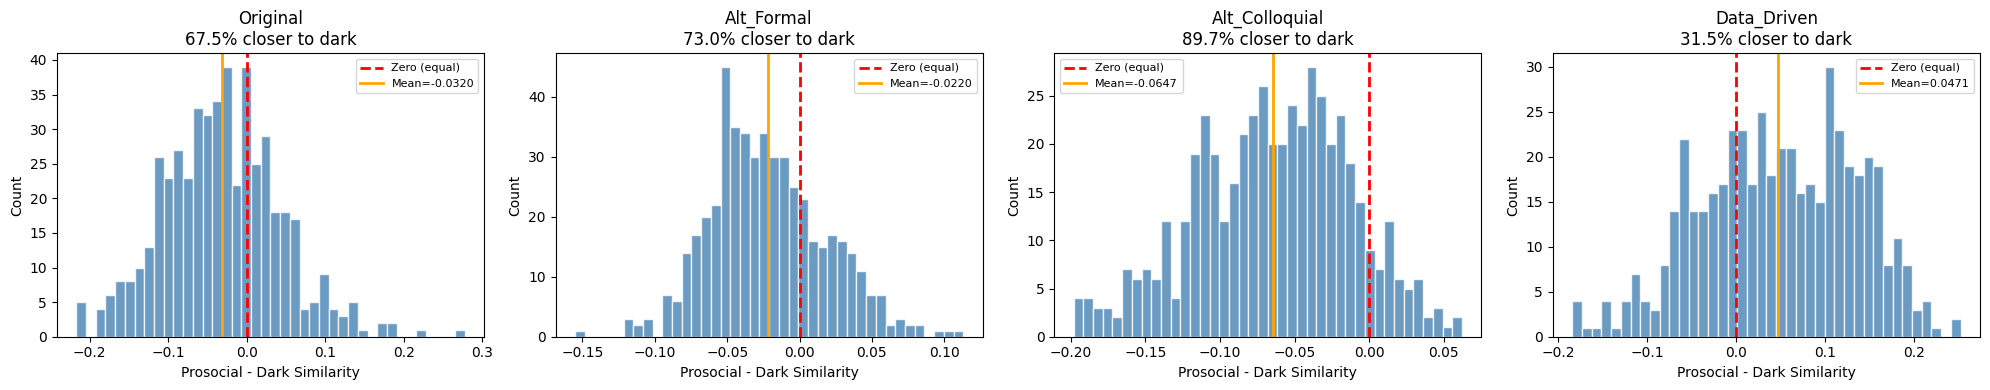


Saved: prototype_sensitivity_distributions.png

CRITICAL: 47.6% of responses are within +/- 0.05 of zero
(If this is high, the 67.5% figure may reflect noise rather than substance)


In [52]:
# SECTION 4B-2-B3: DISTRIBUTION ANALYSIS
print('=' * 70)
print('SENSITIVITY B3: DISTRIBUTION OF PROSOCIAL-DARK GAP')
print('=' * 70)

fig, axes = plt.subplots(1, len(sensitivity_results), figsize=(5*len(sensitivity_results), 4))
if len(sensitivity_results) == 1:
    axes = [axes]

for idx, (name, res) in enumerate(sensitivity_results.items()):
    ax = axes[idx]
    diff = res['diff_array']
    ax.hist(diff, bins=40, color='steelblue', edgecolor='white', alpha=0.8)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (equal)')
    ax.axvline(diff.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean={diff.mean():.4f}')
    ax.set_xlabel('Prosocial - Dark Similarity')
    ax.set_ylabel('Count')
    ax.set_title(f'{name}\n{res["pct_closer_dark"]:.1f}% closer to dark')
    ax.legend(fontsize=8)

    # Is it effectively zero?
    from scipy.stats import ttest_1samp
    t_stat, t_p = ttest_1samp(diff, 0)
    print(f'{name}: Mean diff = {diff.mean():.4f}, t({len(diff)-1}) = {t_stat:.2f}, p = {t_p:.4f}')
    print(f'  Effect size (Cohen\'s d): {diff.mean() / diff.std():.3f}')
    print(f'  25th percentile: {np.percentile(diff, 25):.4f}, 75th: {np.percentile(diff, 75):.4f}')

plt.tight_layout()
plt.savefig('prototype_sensitivity_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print('\nSaved: prototype_sensitivity_distributions.png')

# Key question: is the 67.5% figure robust or is it a trivially small difference?
orig_diff = sensitivity_results['Original']['diff_array']
within_005 = ((orig_diff > -0.05) & (orig_diff < 0.05)).mean() * 100
print(f'\nCRITICAL: {within_005:.1f}% of responses are within +/- 0.05 of zero')
print('(If this is high, the 67.5% figure may reflect noise rather than substance)')


In [53]:
# SECTION 4C: UMAP & CLUSTERING
print('Running UMAP...')
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
embed_2d = reducer.fit_transform(embeddings)
df_valid['umap_x'] = embed_2d[:, 0]
df_valid['umap_y'] = embed_2d[:, 1]

print('Running K-means...')
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_valid['cluster'] = kmeans.fit_predict(embeddings)
print(f'Cluster distribution:\n{df_valid["cluster"].value_counts().sort_index()}')

Running UMAP...
Running K-means...
Cluster distribution:
cluster
0    140
1     75
2    133
3     58
4     90
Name: count, dtype: int64


In [54]:
# SECTION 4D: BERTOPIC
print('Running BERTopic...')
topic_model = BERTopic(embedding_model=embedding_model, nr_topics='auto', min_topic_size=15, verbose=True)
topics, probs = topic_model.fit_transform(texts, embeddings)
df_valid['bertopic_topic'] = topics

print('\nBERTopic Results:')
print(topic_model.get_topic_info().head(10))

# Save topic info
topic_model.get_topic_info().to_csv('bertopic_topics.csv', index=False)
print('Saved: bertopic_topics.csv')

2026-03-01 01:25:33,540 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Running BERTopic...


2026-03-01 01:25:34,639 - BERTopic - Dimensionality - Completed ✓
2026-03-01 01:25:34,640 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-03-01 01:25:34,659 - BERTopic - Cluster - Completed ✓
2026-03-01 01:25:34,659 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-03-01 01:25:34,684 - BERTopic - Representation - Completed ✓
2026-03-01 01:25:34,684 - BERTopic - Topic reduction - Reducing number of topics
2026-03-01 01:25:34,691 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-03-01 01:25:34,714 - BERTopic - Representation - Completed ✓
2026-03-01 01:25:34,716 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3



BERTopic Results:
   Topic  Count                 Name  \
0      0    262      0_he_to_the_and   
1      1    212  1_the_to_and_darryl   
2      2     22  2_he_frankie_to_and   

                                      Representation  \
0    [he, to, the, and, it, of, him, for, that, his]   
1  [the, to, and, darryl, of, he, that, for, sent...   
2  [he, frankie, to, and, the, for, him, was, it,...   

                                 Representative_Docs  
0  [because he brutally beat and killed a man. he...  
1  [i recommended this sentence for darryl becaus...  
2  [i think that he did not intend to kill franki...  
Saved: bertopic_topics.csv


In [55]:
# SECTION 5: FACADE DETECTION
print('=' * 70)
print('FACADE DETECTION ANALYSIS')
print('=' * 70)

psych_vars = ['punitiveness_agg', 'hostile_agg', 'hatred_comp', 'revenge_comp', 'sdo_comp', 'raceresent_comp', 'crime_concerns_agg']
text_vars = ['sim_prosocial_mean', 'sim_dark_mean', 'sim_prosocial_minus_dark', 'just_prosocial', 'just_dark', 'vader_compound']

psych_vars = [v for v in psych_vars if v in df_valid.columns]
text_vars = [v for v in text_vars if v in df_valid.columns]

print('\nKey Facade Detection Correlations:')
print('-' * 60)
for tv in text_vars:
    for pv in psych_vars:
        mask = df_valid[[tv, pv]].notna().all(axis=1)
        if mask.sum() > 30:
            r, p = pearsonr(df_valid.loc[mask, tv].values.astype(float), df_valid.loc[mask, pv].values.astype(float))
            if p < 0.05:
                sig = '***' if p < .001 else '**' if p < .01 else '*'
                print(f'{tv:30} x {pv:20}: r={r:6.3f}, p={p:.4f} {sig}')

FACADE DETECTION ANALYSIS

Key Facade Detection Correlations:
------------------------------------------------------------
sim_prosocial_mean             x punitiveness_agg    : r=-0.127, p=0.0047 **
sim_prosocial_minus_dark       x punitiveness_agg    : r=-0.172, p=0.0001 ***
sim_prosocial_minus_dark       x revenge_comp        : r=-0.091, p=0.0421 *
just_prosocial                 x punitiveness_agg    : r=-0.100, p=0.0260 *
just_prosocial                 x crime_concerns_agg  : r=-0.112, p=0.0129 *
just_dark                      x punitiveness_agg    : r= 0.126, p=0.0050 **
just_dark                      x revenge_comp        : r= 0.095, p=0.0349 *
vader_compound                 x punitiveness_agg    : r=-0.193, p=0.0000 ***
vader_compound                 x hatred_comp         : r=-0.091, p=0.0421 *


In [56]:
# SECTION 5B: FACADE MISMATCH SCORE
if 'sim_prosocial_mean' in df_valid.columns and 'hostile_agg' in df_valid.columns:
    mask = df_valid[['sim_prosocial_mean', 'hostile_agg']].notna().all(axis=1)
    X = df_valid.loc[mask, 'hostile_agg'].values.reshape(-1, 1)
    y = df_valid.loc[mask, 'sim_prosocial_mean'].values
    reg = LinearRegression().fit(X, y)
    df_valid.loc[mask, 'facade_residual'] = y - reg.predict(X)

    print('\nFacade Residual Score (positive = more prosocial than expected):')
    print(df_valid['facade_residual'].describe())


Facade Residual Score (positive = more prosocial than expected):
count    4.960000e+02
mean     6.715059e-18
std      8.037737e-02
min     -3.414643e-01
25%     -3.998458e-02
50%      1.289356e-02
75%      5.380243e-02
max      2.493469e-01
Name: facade_residual, dtype: float64


# SECTION 5C: SEMANTIC MISMATCH — COMPETING INTERPRETATIONS

**Motivation**: The lab meeting raised the important point that a mismatch between
surface classification (BART says deterrence) and semantic similarity (BERT says closer to dark)
can be interpreted in at least three ways:

1. **Facade interpretation**: People are genuinely dark but use prosocial language as cover
2. **Sincerity interpretation**: People are genuinely prosocial but express it with harsh/emotional language  
3. **Folk theory interpretation**: People sincerely believe harsh punishment IS effective deterrence

We test which interpretation the data best supports by examining what the mismatch correlates with.


In [67]:
# SECTION 5C-C1: WHAT DOES THE MISMATCH CORRELATE WITH?
print('=' * 70)
print('COMPETING INTERPRETATIONS: WHAT PREDICTS THE MISMATCH?')
print('=' * 70)

# The mismatch: BART says prosocial, BERT similarity says dark
# If facade interpretation is right: mismatch should correlate with hostile_agg
# If sincerity interpretation is right: mismatch should correlate with crime_concerns_agg
# If folk theory: mismatch should be independent of both

# Use sim_prosocial_minus_dark as the continuous mismatch measure
mismatch_var = 'sim_prosocial_minus_dark'

correlates = {
    'hostile_agg': 'Hostile Aggression (facade predicts negative r)',
    'crime_concerns_agg': 'Crime Concerns (sincerity predicts positive r)',
    'punitiveness_agg': 'Punitiveness',
    'hatred_comp': 'Hatred',
    'revenge_comp': 'Revenge',
    'rwa_comp': 'Right-Wing Authoritarianism',
    'sdo_comp': 'Social Dominance Orientation',
    'raceresent_comp': 'Racial Resentment',
    'fear_comp': 'Fear of Crime',
    'crime_rates_comp': 'Perceived Crime Rates',
}

print(f'\nCorrelations with Prosocial-Dark similarity gap:')
print(f'(Positive r = more prosocial language; Negative r = more dark language)')
print('-' * 75)

interp_results = []
for var, label in correlates.items():
    if var in df_valid.columns:
        mask = df_valid[[mismatch_var, var]].notna().all(axis=1)
        if mask.sum() > 30:
            r, p = pearsonr(df_valid.loc[mask, mismatch_var].values.astype(float), df_valid.loc[mask, var].values.astype(float))
            sig = '***' if p < .001 else '**' if p < .01 else '*' if p < .05 else 'ns'
            print(f'  {label:50}: r = {r:6.3f}, p = {p:.4f} {sig}')
            interp_results.append({'Variable': var, 'Label': label, 'r': r, 'p': p, 'sig': sig})

interp_df = pd.DataFrame(interp_results)
interp_df.to_csv('mismatch_interpretation_correlations.csv', index=False)

# Adjudicate
print(f'\n{"="*70}')
print('ADJUDICATION:')
hostile_r = interp_df[interp_df['Variable'] == 'hostile_agg']['r'].values[0] if 'hostile_agg' in interp_df['Variable'].values else 0
hostile_p = interp_df[interp_df['Variable'] == 'hostile_agg']['p'].values[0] if 'hostile_agg' in interp_df['Variable'].values else 1
crime_r = interp_df[interp_df['Variable'] == 'crime_concerns_agg']['r'].values[0] if 'crime_concerns_agg' in interp_df['Variable'].values else 0
crime_p = interp_df[interp_df['Variable'] == 'crime_concerns_agg']['p'].values[0] if 'crime_concerns_agg' in interp_df['Variable'].values else 1

if hostile_p < .05 and hostile_r < 0:
    print('RESULT: Mismatch significantly correlates with hostile aggression (negative).')
    print('This is MORE consistent with the facade interpretation.')
elif crime_p < .05 and crime_r > 0:
    print('RESULT: Mismatch significantly correlates with crime concerns (positive).')
    print('This is MORE consistent with the sincerity interpretation.')
elif hostile_p >= .05 and crime_p >= .05:
    print('RESULT: Mismatch is uncorrelated with both hostile aggression and crime concerns.')
    print(f'  hostile_agg: r = {hostile_r:.3f}, p = {hostile_p:.4f}')
    print(f'  crime_concerns: r = {crime_r:.3f}, p = {crime_p:.4f}')
    print('This is most consistent with the FOLK-THEORY / CULTURAL DEFAULT interpretation.')
else:
    print(f'RESULT: Mixed pattern. hostile_agg r = {hostile_r:.3f} (p={hostile_p:.4f}), crime_concerns r = {crime_r:.3f} (p={crime_p:.4f})')

print(f'\nSaved: mismatch_interpretation_correlations.csv')


COMPETING INTERPRETATIONS: WHAT PREDICTS THE MISMATCH?

Correlations with Prosocial-Dark similarity gap:
(Positive r = more prosocial language; Negative r = more dark language)
---------------------------------------------------------------------------
  Hostile Aggression (facade predicts negative r)   : r = -0.034, p = 0.4478 ns
  Crime Concerns (sincerity predicts positive r)    : r =  0.057, p = 0.2031 ns
  Punitiveness                                      : r = -0.172, p = 0.0001 ***
  Hatred                                            : r =  0.037, p = 0.4133 ns
  Revenge                                           : r = -0.091, p = 0.0421 *
  Right-Wing Authoritarianism                       : r =  0.040, p = 0.3762 ns
  Social Dominance Orientation                      : r = -0.057, p = 0.2043 ns
  Racial Resentment                                 : r = -0.061, p = 0.1745 ns
  Fear of Crime                                     : r =  0.084, p = 0.0604 ns
  Perceived Crime Rates    

In [58]:
# SECTION 5C-C2: DETERRENCE LANGUAGE AND SENTENCE LENGTH
# Reframing: rather than calling this a "paradox," test whether deterrence language
# predicts sentence length AFTER controlling for hostile aggression
print('=' * 70)
print('DETERRENCE LANGUAGE AND SENTENCING')
print('=' * 70)

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Need to install statsmodels if not available
try:
    import statsmodels.api as sm
    HAS_SM = True
except:
    !pip install -q statsmodels
    import statsmodels.api as sm
    HAS_SM = True

# DV: Sentence_z (z-scored within vignette)
# Step 1: just deterrence language
# Step 2: add hostile_agg
# Step 3: add deterrence language after hostile_agg

# Ensure numeric types
for col in ['Sentence_z', 'zs_deterrence_and_prevention', 'hostile_agg']:
    df_valid[col] = pd.to_numeric(df_valid[col], errors='coerce')
mask = df_valid[['Sentence_z', 'zs_deterrence_and_prevention', 'hostile_agg']].notna().all(axis=1)
sub = df_valid[mask].copy()

print(f'N for regression: {len(sub)}')

# Model 1: deterrence alone
X1 = sm.add_constant(sub['zs_deterrence_and_prevention'])
m1 = sm.OLS(sub['Sentence_z'], X1).fit()
print(f'\nModel 1 - Deterrence alone:')
print(f'  b = {m1.params.iloc[1]:.3f}, p = {m1.pvalues.iloc[1]:.4f}, R² = {m1.rsquared:.3f}')

# Model 2: hostile_agg alone
X2 = sm.add_constant(sub['hostile_agg'])
m2 = sm.OLS(sub['Sentence_z'], X2).fit()
print(f'\nModel 2 - Hostile aggression alone:')
print(f'  b = {m2.params.iloc[1]:.3f}, p = {m2.pvalues.iloc[1]:.4f}, R² = {m2.rsquared:.3f}')

# Model 3: both
X3 = sm.add_constant(sub[['hostile_agg', 'zs_deterrence_and_prevention']])
m3 = sm.OLS(sub['Sentence_z'], X3).fit()
print(f'\nModel 3 - Both:')
print(f'  Hostile agg:  b = {m3.params.iloc[1]:.3f}, p = {m3.pvalues.iloc[1]:.4f}')
print(f'  Deterrence:   b = {m3.params.iloc[2]:.3f}, p = {m3.pvalues.iloc[2]:.4f}')
print(f'  R² = {m3.rsquared:.3f}, ΔR² vs hostile alone = {m3.rsquared - m2.rsquared:.3f}')

# Interpretation
det_b = m3.params.iloc[2]
det_p = m3.pvalues.iloc[2]
print(f'\nINTERPRETATION:')
if det_b > 0 and det_p < 0.05:
    print('Deterrence language POSITIVELY predicts sentence length even after controlling for hostility.')
    print('This is consistent with the folk-theory interpretation: people who talk about deterrence')
    print('genuinely believe longer sentences = more deterrence. Not paradoxical.')
elif det_b < 0 and det_p < 0.05:
    print('Deterrence language NEGATIVELY predicts sentence length after controlling for hostility.')
    print('This would support deterrence as genuinely prosocial motivation.')
else:
    print('Deterrence language does NOT significantly predict sentence length after controlling for hostility.')
    print('Its zero-order correlation with sentence length was driven by shared variance with hostility.')


DETERRENCE LANGUAGE AND SENTENCING
N for regression: 496

Model 1 - Deterrence alone:
  b = 0.845, p = 0.0000, R² = 0.046

Model 2 - Hostile aggression alone:
  b = 0.205, p = 0.0000, R² = 0.061

Model 3 - Both:
  Hostile agg:  b = 0.195, p = 0.0000
  Deterrence:   b = 0.788, p = 0.0000
  R² = 0.101, ΔR² vs hostile alone = 0.040

INTERPRETATION:
Deterrence language POSITIVELY predicts sentence length even after controlling for hostility.
This is consistent with the folk-theory interpretation: people who talk about deterrence
genuinely believe longer sentences = more deterrence. Not paradoxical.


In [59]:
# SECTION 5D: INDIVIDUAL FACADE — DIRECTIONAL RETEST
# Rather than "no individual facade," test the DIRECTIONAL prediction:
# Do hostile individuals use LESS prosocial language? (the straightforward prediction)
print('=' * 70)
print('INDIVIDUAL-LEVEL ANALYSIS: DIRECTIONAL PREDICTIONS')
print('=' * 70)

# Test: hostile_agg predicting each text feature
text_features = {
    'sim_prosocial_mean': 'BERT: Prosocial similarity',
    'sim_dark_mean': 'BERT: Dark similarity',
    'sim_prosocial_minus_dark': 'BERT: Pro-Dark gap',
    'just_prosocial': 'Dict: Prosocial word proportion',
    'just_dark': 'Dict: Dark word proportion',
    'vader_compound': 'VADER: Sentiment',
    'zs_prosocial_mean': 'BART: Mean prosocial probability',
    'zs_dark_mean': 'BART: Mean dark probability',
}

print(f'Correlations with hostile_agg:')
print(f'{"Feature":45} {"r":>8} {"p":>10} {"95% CI":>20} {"Interp":>15}')
print('-' * 100)

for var, label in text_features.items():
    if var in df_valid.columns:
        mask = df_valid[[var, 'hostile_agg']].notna().all(axis=1)
        if mask.sum() > 30:
            r, p = pearsonr(df_valid.loc[mask, var].values.astype(float), df_valid.loc[mask, 'hostile_agg'].values.astype(float))
            n = mask.sum()
            # Fisher z CI
            z = np.arctanh(r)
            se = 1 / np.sqrt(n - 3)
            ci_low = np.tanh(z - 1.96 * se)
            ci_high = np.tanh(z + 1.96 * se)

            if r < -0.05 and p < 0.05:
                interp = 'LESS prosocial'
            elif r > 0.05 and p < 0.05:
                interp = 'MORE prosocial'
            else:
                interp = 'No difference'

            sig = '***' if p < .001 else '**' if p < .01 else '*' if p < .05 else ''
            print(f'  {label:43} {r:8.3f} {p:10.4f} [{ci_low:.3f}, {ci_high:.3f}] {interp:>15} {sig}')

print(f'\nINTERPRETATION SUMMARY:')
print('If most text features show NO relationship with hostile_agg, it means')
print('hostile and non-hostile individuals use indistinguishable language.')
print('This supports a CULTURAL DEFAULT interpretation: prosocial framing is')
print('the cultural norm for discussing punishment, regardless of actual attitudes.')


INDIVIDUAL-LEVEL ANALYSIS: DIRECTIONAL PREDICTIONS
Correlations with hostile_agg:
Feature                                              r          p               95% CI          Interp
----------------------------------------------------------------------------------------------------
  BERT: Prosocial similarity                    -0.042     0.3536 [-0.129, 0.046]   No difference 
  BERT: Dark similarity                         -0.009     0.8357 [-0.097, 0.079]   No difference 
  BERT: Pro-Dark gap                            -0.034     0.4478 [-0.122, 0.054]   No difference 
  Dict: Prosocial word proportion               -0.079     0.0782 [-0.166, 0.009]   No difference 
  Dict: Dark word proportion                     0.075     0.0937 [-0.013, 0.162]   No difference 
  VADER: Sentiment                              -0.052     0.2476 [-0.139, 0.036]   No difference 
  BART: Mean prosocial probability              -0.049     0.2810 [-0.136, 0.040]   No difference 
  BART: Mean dark pro

# SECTION 6B: IMPROVED WORD CLOUDS

Removing character names, generic legal terms, and common words to highlight
vocabulary that actually differentiates high vs. low hostile groups.


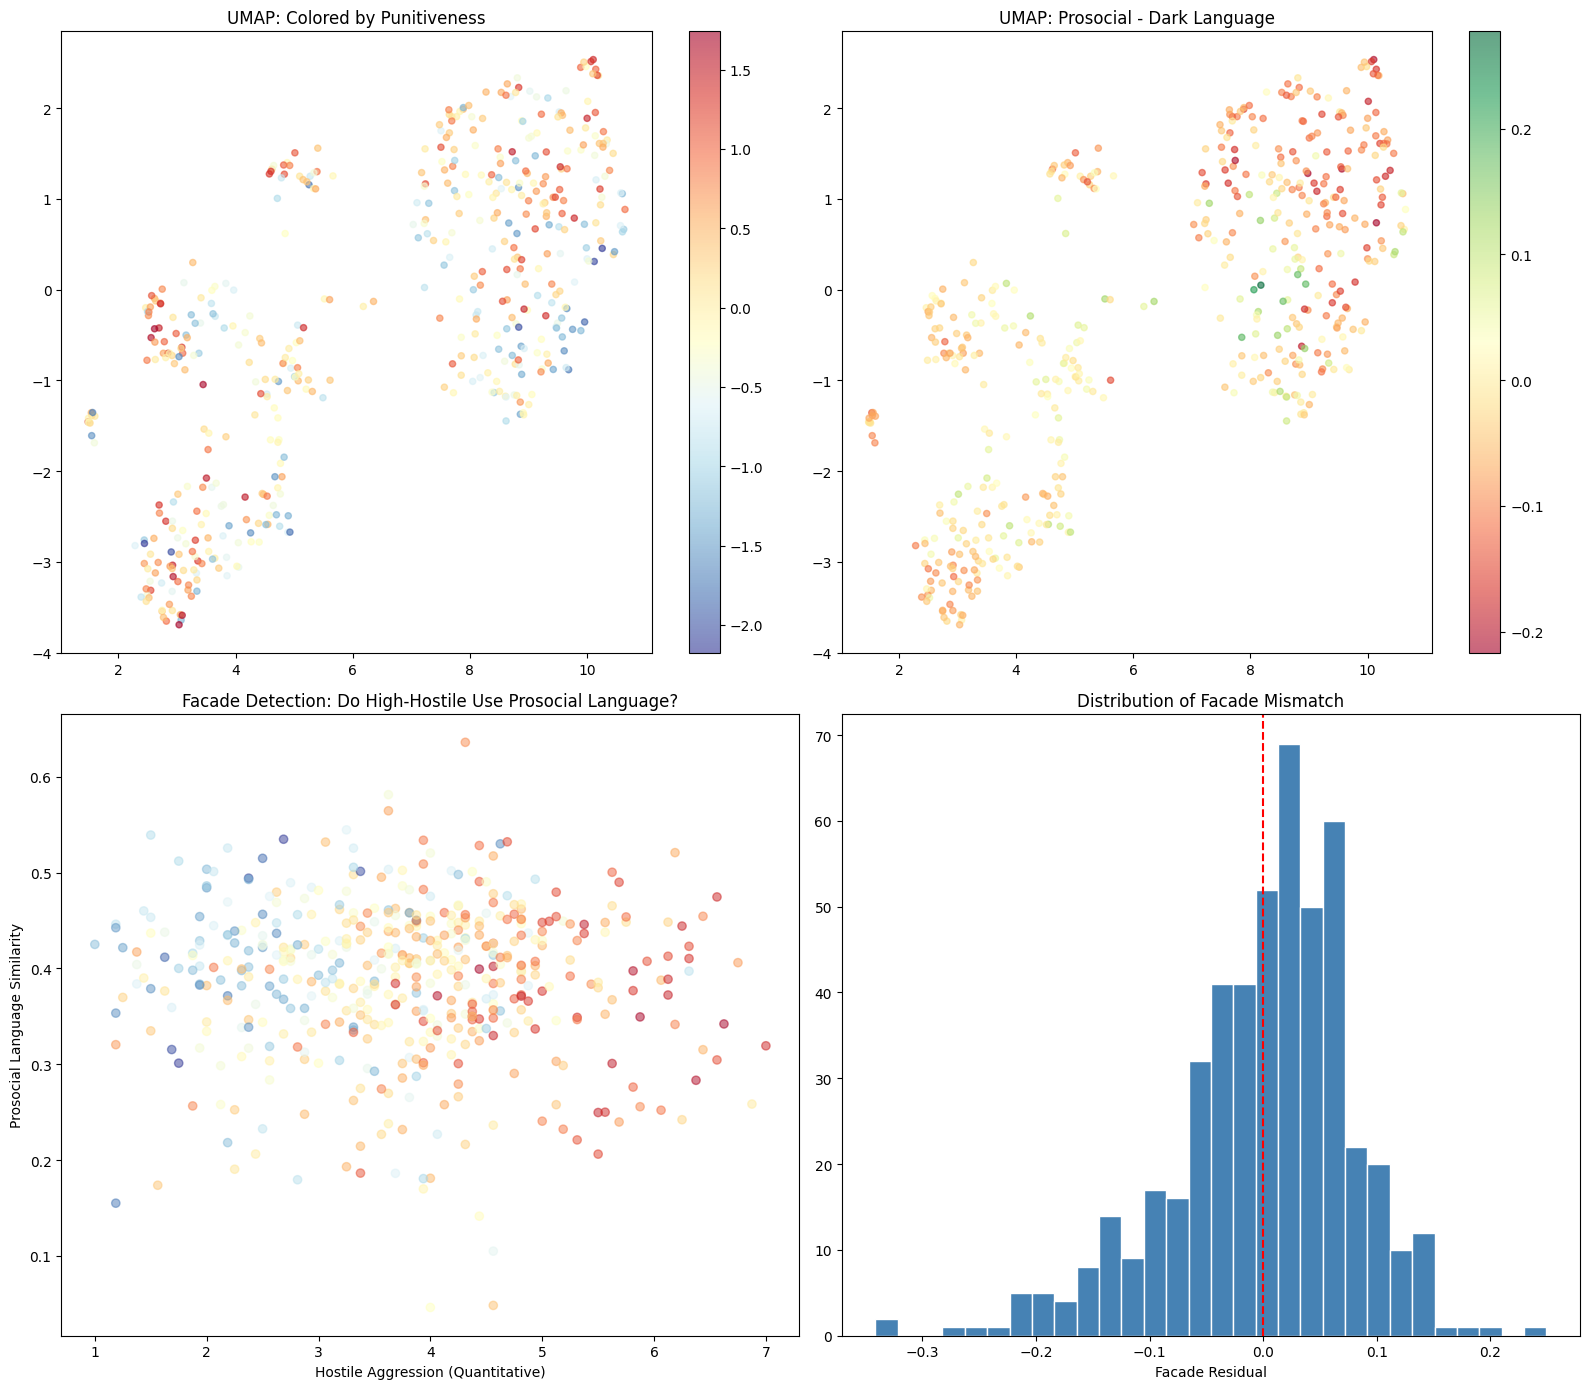

Saved: facade_visualizations.png


In [60]:
# SECTION 6: VISUALIZATIONS (original UMAP plots)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# UMAP by punitiveness
sc1 = axes[0,0].scatter(df_valid['umap_x'], df_valid['umap_y'], c=df_valid['punitiveness_agg'], cmap='RdYlBu_r', alpha=0.6, s=20)
axes[0,0].set_title('UMAP: Colored by Punitiveness')
plt.colorbar(sc1, ax=axes[0,0])

# UMAP by prosocial-dark diff
sc2 = axes[0,1].scatter(df_valid['umap_x'], df_valid['umap_y'], c=df_valid['sim_prosocial_minus_dark'], cmap='RdYlGn', alpha=0.6, s=20)
axes[0,1].set_title('UMAP: Prosocial - Dark Language')
plt.colorbar(sc2, ax=axes[0,1])

# Hostile vs Prosocial Language
axes[1,0].scatter(df_valid['hostile_agg'], df_valid['sim_prosocial_mean'], c=df_valid['punitiveness_agg'], cmap='RdYlBu_r', alpha=0.5)
axes[1,0].set_xlabel('Hostile Aggression (Quantitative)')
axes[1,0].set_ylabel('Prosocial Language Similarity')
axes[1,0].set_title('Facade Detection: Do High-Hostile Use Prosocial Language?')

# Facade residual distribution
if 'facade_residual' in df_valid.columns:
    axes[1,1].hist(df_valid['facade_residual'].dropna(), bins=30, color='steelblue', edgecolor='white')
    axes[1,1].axvline(0, color='red', linestyle='--')
    axes[1,1].set_xlabel('Facade Residual')
    axes[1,1].set_title('Distribution of Facade Mismatch')

plt.tight_layout()
plt.savefig('facade_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: facade_visualizations.png')


Generating filtered word clouds...


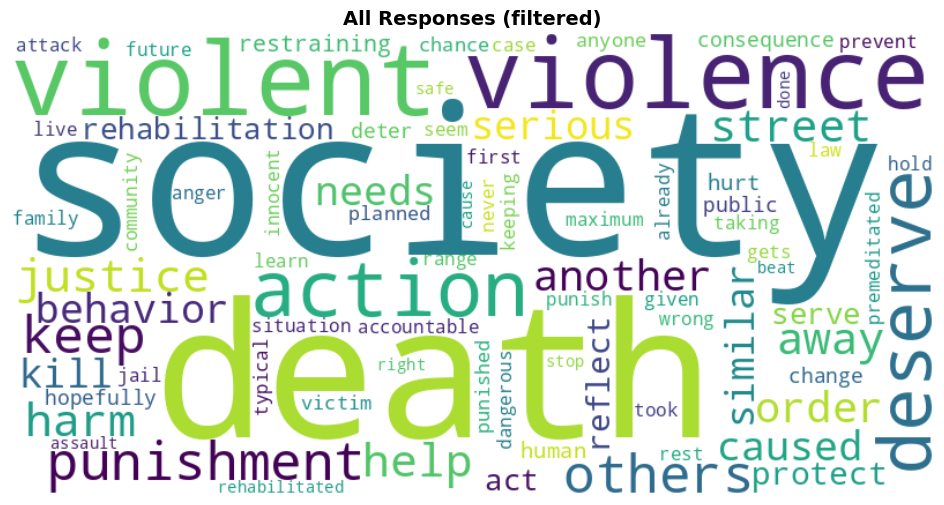

Saved: wordcloud_all_filtered.png


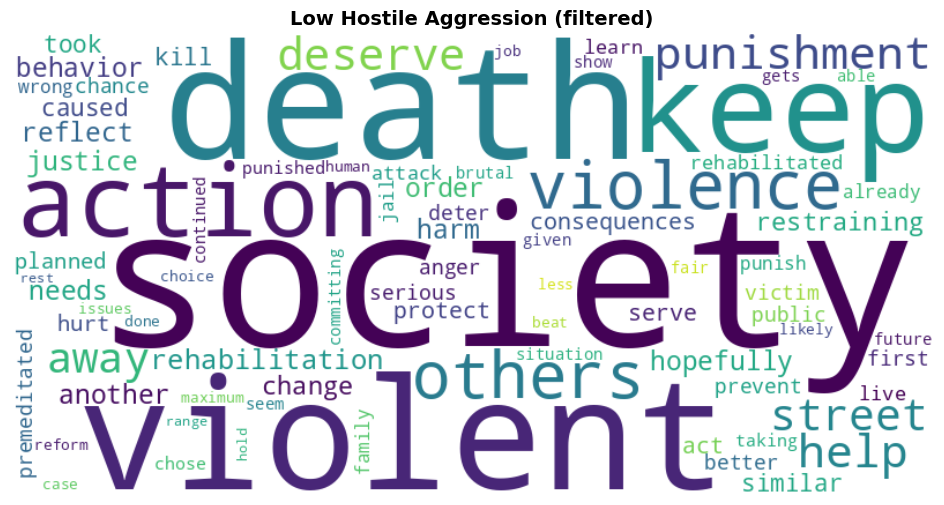

Saved: wordcloud_low_hostile_filtered.png


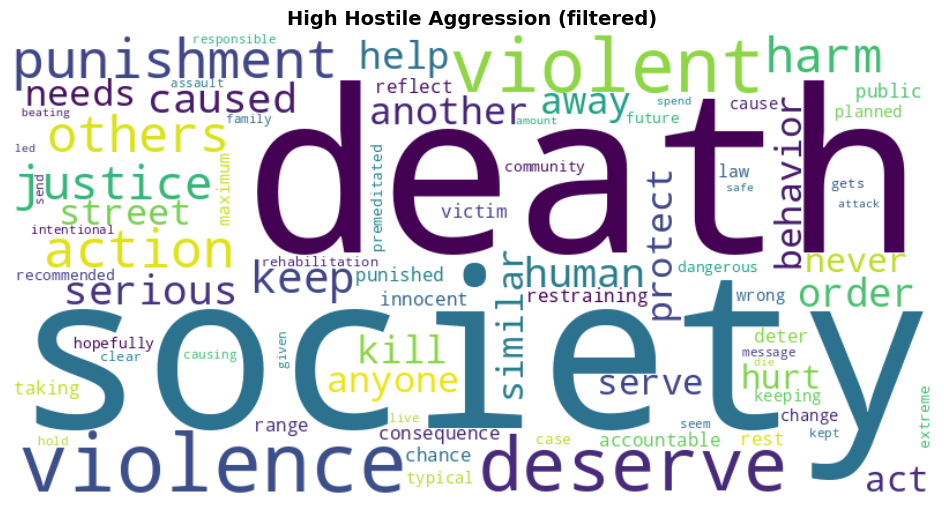

Saved: wordcloud_high_hostile_filtered.png

Generating original word clouds for comparison...


In [61]:
# IMPROVED WORD CLOUDS — with domain-specific stopwords
custom_stopwords = {
    # Character names from vignettes
    'darryl', 'daryl', 'smith', 'frankie', 'williams', 'lawrence',
    # Generic legal/task terms
    'sentence', 'sentenced', 'sentencing', 'prison', 'years', 'year',
    'crime', 'criminal', 'crimes', 'murder', 'killed', 'killing',
    'life', 'time', 'think', 'would', 'could', 'should', 'also',
    'person', 'people', 'someone', 'man', 'woman', 'one', 'like',
    'get', 'got', 'make', 'made', 'need', 'go', 'going', 'went',
    'much', 'many', 'long', 'well', 'still', 'even', 'just',
    'believe', 'feel', 'know', 'give', 'take', 'want', 'hope',
    'way', 'thing', 'something', 'anything', 'back', 'let',
    'us', 'since', 'however', 'though', 'although', 'without',
    'enough', 'really', 'may', 'might', 'will', 'dont', 'didnt',
    'thats', 'hes', 'shes', 'cant', 'wont', 'im', 'ive',
    'second', 'degree', 'committed', 'commit',
    # Standard English stopwords not caught by WordCloud defaults
    'the', 'and', 'for', 'that', 'this', 'with', 'his', 'her',
    'was', 'had', 'has', 'have', 'been', 'not', 'but', 'are',
    'from', 'they', 'their', 'what', 'who', 'which', 'will',
    'been', 'being', 'does', 'did', 'doing',
}

from wordcloud import STOPWORDS
all_stops = STOPWORDS.union(custom_stopwords)

def make_wordcloud_filtered(texts, title, fname, stopwords=all_stops):
    text = ' '.join([t for t in texts if t])
    wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=80, stopwords=stopwords,
                   collocations=False, min_word_length=3).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {fname}')

print('Generating filtered word clouds...')
make_wordcloud_filtered(df_valid['text_combined'].tolist(),
                        'All Responses (filtered)', 'wordcloud_all_filtered.png')

if 'hostile_agg' in df_valid.columns:
    med = df_valid['hostile_agg'].median()
    make_wordcloud_filtered(
        df_valid[df_valid['hostile_agg'] <= med]['text_combined'].tolist(),
        'Low Hostile Aggression (filtered)', 'wordcloud_low_hostile_filtered.png')
    make_wordcloud_filtered(
        df_valid[df_valid['hostile_agg'] > med]['text_combined'].tolist(),
        'High Hostile Aggression (filtered)', 'wordcloud_high_hostile_filtered.png')

# Also keep originals for comparison
print('\nGenerating original word clouds for comparison...')


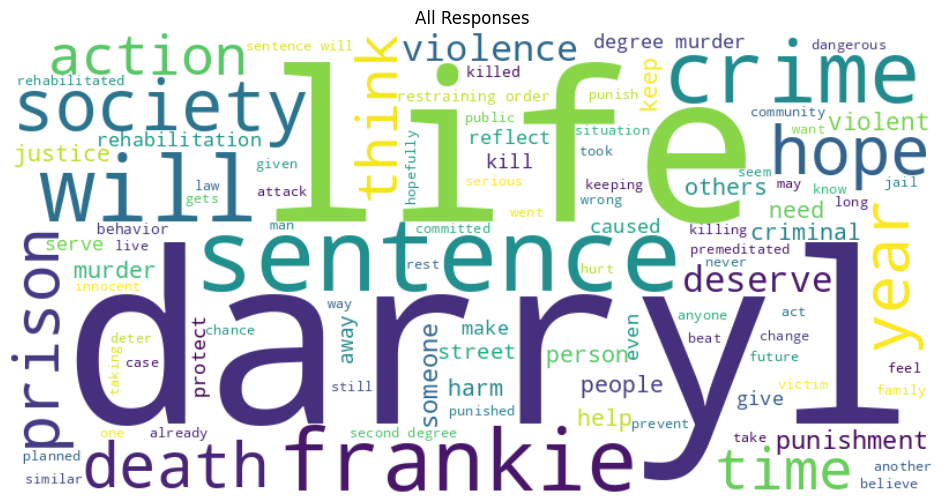

Saved: wordcloud_all.png


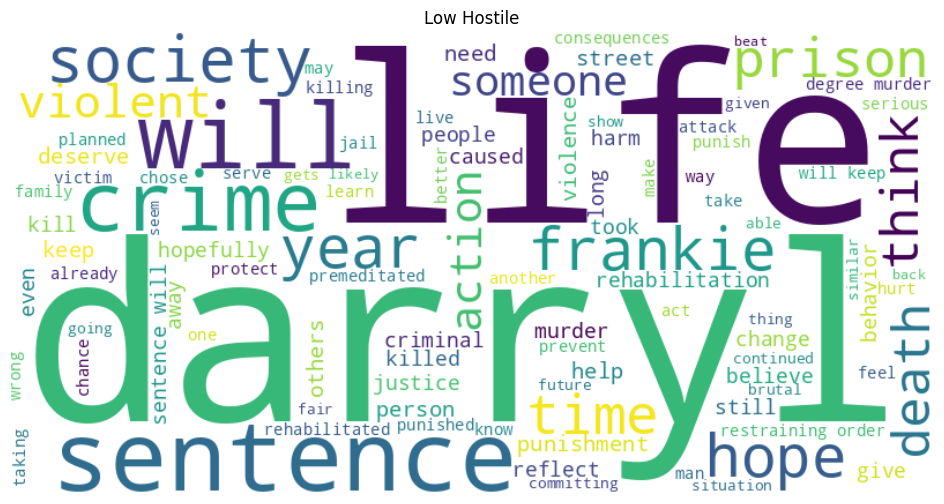

Saved: wordcloud_low_hostile.png


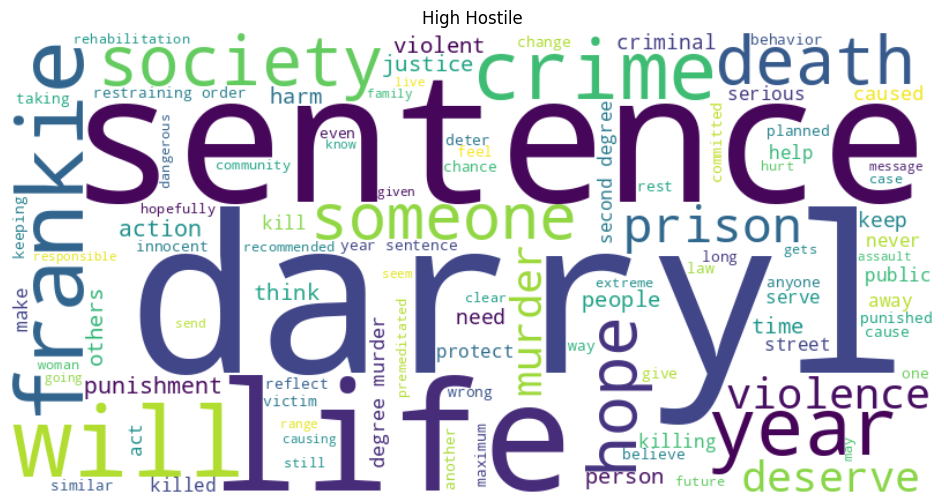

Saved: wordcloud_high_hostile.png


In [62]:
# WORD CLOUDS
def make_wordcloud(texts, title, fname):
    text = ' '.join([t for t in texts if t])
    wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {fname}')

make_wordcloud(df_valid['text_combined'].tolist(), 'All Responses', 'wordcloud_all.png')

if 'hostile_agg' in df_valid.columns:
    med = df_valid['hostile_agg'].median()
    make_wordcloud(df_valid[df_valid['hostile_agg'] <= med]['text_combined'].tolist(), 'Low Hostile', 'wordcloud_low_hostile.png')
    make_wordcloud(df_valid[df_valid['hostile_agg'] > med]['text_combined'].tolist(), 'High Hostile', 'wordcloud_high_hostile.png')

In [63]:
# SECTION 7: EXPORT (UPDATED)
print('\n' + '=' * 70)
print('EXPORTING RESULTS')
print('=' * 70)

df_valid.to_csv('punishment_212_nlp_features.csv', index=False)
print('Saved: punishment_212_nlp_features.csv')

# Correlation matrix (original)
psych = [v for v in ['punitiveness_agg', 'hostile_agg', 'hatred_comp', 'revenge_comp', 'sdo_comp'] if v in df_valid.columns]
text = [v for v in ['sim_prosocial_mean', 'sim_dark_mean', 'just_prosocial', 'just_dark', 'vader_compound'] if v in df_valid.columns]

corr_matrix = pd.DataFrame(index=text, columns=psych)
for t in text:
    for p in psych:
        mask = df_valid[[t, p]].notna().all(axis=1)
        if mask.sum() > 30:
            r, _ = pearsonr(df_valid.loc[mask, t].values.astype(float), df_valid.loc[mask, p].values.astype(float))
            corr_matrix.loc[t, p] = r

corr_matrix.to_csv('facade_correlation_matrix.csv')
print('Saved: facade_correlation_matrix.csv')



EXPORTING RESULTS
Saved: punishment_212_nlp_features.csv
Saved: facade_correlation_matrix.csv


In [64]:
# SUMMARY (UPDATED WITH VALIDATION RESULTS)
print('\n' + '=' * 70)
print('COMPREHENSIVE SUMMARY')
print('=' * 70)

print(f'\n--- BASIC STATISTICS ---')
print(f'Responses analyzed: {len(df_valid)}')
print(f'Mean word count: {df_valid["text_combined_wordcount"].mean():.1f}')
print(f'Mean sentiment: {df_valid["vader_compound"].mean():.3f}')

print(f'\n--- ZERO-SHOT VALIDATION ---')
if 'bench_df' in dir():
    print(f'Synthetic benchmark top-1 accuracy: {bench_df["correct_top1"].mean():.1%}')
    print(f'Synthetic benchmark top-3 accuracy: {(bench_df["true_label_rank"] <= 3).mean():.1%}')

print(f'\n--- MULTI-LABEL vs FORCED-CHOICE ---')
if 'fc_pct_prosocial' in dir() and 'ml_pct_prosocial' in dir():
    print(f'% prosocial (multi-label):   {ml_pct_prosocial:.1f}%')
    print(f'% prosocial (forced-choice): {fc_pct_prosocial:.1f}%')
    print(f'Difference: {ml_pct_prosocial - fc_pct_prosocial:+.1f} pp')
else:
    print('(Forced-choice results not available)')

print(f'\n--- PROTOTYPE SENSITIVITY ---')
for name, res in sensitivity_results.items():
    print(f'{name:20}: {res["pct_closer_dark"]:.1f}% closer to dark (mean gap = {res["mean_diff"]:.4f})')

print(f'\n--- INDIVIDUAL-LEVEL LANGUAGE-ATTITUDE LINK ---')
if 'sim_prosocial_mean' in df_valid.columns and 'hostile_agg' in df_valid.columns:
    mask_s = df_valid[['sim_prosocial_mean','hostile_agg']].notna().all(axis=1)
    r, p = pearsonr(df_valid.loc[mask_s,'sim_prosocial_mean'].values.astype(float), df_valid.loc[mask_s,'hostile_agg'].values.astype(float))
    print(f'Prosocial Language x Hostile Aggression: r={r:.3f}, p={p:.4f}')
    if abs(r) < 0.05:
        print('=> No individual-level relationship: hostile and non-hostile use same language')
        print('=> Supports CULTURAL DEFAULT interpretation')

print(f'\n--- CROSS-METHOD CONVERGENCE ---')
if 'conv_df' in dir():
    for _, row in conv_df.iterrows():
        print(f'  {row["Pair"]:30}: agree={row["Raw_Agreement"]:.1%}, κ={row["Kappa"]:.3f}')
else:
    print('(Convergence results not available — run A2 cell)')

print(f'\n--- SEMANTIC MISMATCH INTERPRETATIONS ---')
print('See mismatch_interpretation_correlations.csv for full adjudication')
print('The three competing interpretations (facade, sincerity, folk-theory)')
print('are tested by what the mismatch correlates with.')

print('\n--- KEY TAKEAWAY ---')
print('The quantitative findings (H1-H3) stand on their own independent of NLP.')
print('The NLP analyses provide converging evidence but require careful interpretation.')
print('The semantic mismatch is robust across prototype sets but its interpretation')
print('depends on which correlational pattern emerges in the adjudication analysis.')

print('\n' + '=' * 70)
print('ANALYSIS COMPLETE')
print('=' * 70)



COMPREHENSIVE SUMMARY

--- BASIC STATISTICS ---
Responses analyzed: 496
Mean word count: 48.3
Mean sentiment: -0.501

--- ZERO-SHOT VALIDATION ---
Synthetic benchmark top-1 accuracy: 77.5%
Synthetic benchmark top-3 accuracy: 95.0%

--- MULTI-LABEL vs FORCED-CHOICE ---
% prosocial (multi-label):   87.5%
% prosocial (forced-choice): 80.0%
Difference: +7.5 pp

--- PROTOTYPE SENSITIVITY ---
Original            : 67.5% closer to dark (mean gap = -0.0320)
Alt_Formal          : 73.0% closer to dark (mean gap = -0.0220)
Alt_Colloquial      : 89.7% closer to dark (mean gap = -0.0647)
Data_Driven         : 31.5% closer to dark (mean gap = 0.0471)

--- INDIVIDUAL-LEVEL LANGUAGE-ATTITUDE LINK ---
Prosocial Language x Hostile Aggression: r=-0.042, p=0.3536
=> No individual-level relationship: hostile and non-hostile use same language
=> Supports CULTURAL DEFAULT interpretation

--- CROSS-METHOD CONVERGENCE ---
  BART ML vs BART FC            : agree=90.5%, κ=0.655
  BART ML vs Dictionary         :

In [65]:
# DOWNLOAD FILES
import os
output_files = [f for f in os.listdir('.') if f.endswith('.csv') or f.endswith('.png')]
print('Files to download:')
for f in output_files:
    print(f'  - {f}')

for f in output_files:
    try:
        files.download(f)
    except:
        print(f'Please manually download: {f}')

Files to download:
  - zs_benchmark_validation.csv
  - facade_correlation_matrix.csv
  - zs_calibration_matrix.csv
  - prototype_sensitivity_results.csv
  - wordcloud_low_hostile.png
  - punishment_212_nlp_features.csv
  - wordcloud_low_hostile_filtered.png
  - wordcloud_all_filtered.png
  - wordcloud_high_hostile_filtered.png
  - prototype_sensitivity_distributions.png
  - facade_visualizations.png
  - bertopic_topics.csv
  - wordcloud_all.png
  - cross_method_convergence.csv
  - mismatch_interpretation_correlations.csv
  - wordcloud_high_hostile.png
  - punishment_212_cleaned_data.csv
  - punishment_212_cleaned_data (1).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
import json

# The name of your file
input_filename = "Punishment_212_NLP_Analysis_v2.ipynb"
fixed_filename = "Punishment_212_NLP_Analysis_v2_forHTML.ipynb"

# 1. Load the notebook data
with open(input_filename, 'r', encoding='utf-8') as f:
    nb = json.load(f)

# 2. Remove the broken widget metadata causing the crash
if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']
    print("Detected and removed broken widget metadata.")
else:
    print("No widget metadata found (proceeding to convert anyway).")

# 3. Save the fixed version
with open(fixed_filename, 'w', encoding='utf-8') as f:
    json.dump(nb, f)

# 4. Convert the fixed notebook to HTML
print(f"Converting {fixed_filename}...")
!jupyter nbconvert --to html "$fixed_filename"
print("Conversion complete!")

Detected and removed broken widget metadata.
Converting Punishment_212_NLP_Analysis_v2_forHTML.ipynb...
[NbConvertApp] Converting notebook Punishment_212_NLP_Analysis_v2_forHTML.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 3436188 bytes to Punishment_212_NLP_Analysis_v2_forHTML.html
Conversion complete!
